<a href="https://colab.research.google.com/github/dekemarquardt/repo/blob/main/Sample_Subscription_Data_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# print all the outputs in a cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
plt.style.use('seaborn-v0_8-whitegrid')
from datetime import datetime,date
import matplotlib.transforms as mtransforms
from sklearn.cluster import KMeans
import numpy as np
from IPython.display import display
pd.set_option('display.max_rows', 100000)
pd.set_option('display.max_columns', 100000)
pd.options.display.float_format = '{:,.0f}'.format
import datetime

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cp -r "/content/drive/My Drive/FlixoraSample" "/content/"

In [ ]:
import pandas as pd
file_path = '/content/drive/My Drive/FlixoraSample/Subscription_Dataset (1).csv'
df = pd.read_csv(file_path)

In [ ]:
df['transaction_type'].unique()

array(['initial', 'REDUCTION', 'CHURN', 'UPGRADE'], dtype=object)

In [ ]:
df = df.reset_index()
df.rename(columns={'index':'Primary_Key'}, inplace=True)

In [ ]:
df[df['subscription_type']=='BASIC']['subscription_price'].unique()

array([33, 53, 43])

In [ ]:
df[df['subscription_type']=='PRO']['subscription_price'].unique()

array([85, 65, 75])

In [ ]:
df[df['subscription_type']=='MAX']['subscription_price'].unique()

array([ 99, 119, 109])

Subscription price increases from 33-43-53 by the beginning of each year for BASIC, 65-75-85 for PRO, 99-109-119

In [ ]:
df[df['cust_id'] == 9765]

Primary_Key  cust_id transaction_type transaction_date  \
17071        17071     9765          initial       2020-08-01   
17072        17072     9765            CHURN       2021-05-01   
17073        17073     9765          UPGRADE       2022-04-01   
17074        17074     9765            CHURN       2022-09-01   
17075        17075     9765            CHURN       2022-11-01   

      subscription_type  subscription_price customer_gender age_group  \
17071               PRO                  65          Female     18-24   
17072               PRO                  75          Female     18-24   
17073               MAX                 119          Female     18-24   
17074               MAX                 119          Female     18-24   
17075               MAX                 119          Female     18-24   

      customer_country referral_type  
17071          Denmark       Unknown  
17072          Denmark       Unknown  
17073          Denmark       Unknown  
17074          Denmark       Unknown  
17075          Denmark       Unknown

Would be unecessary for other companies but the data had instances of two churns in a row, which can't take place

In [ ]:
down_cid = df['cust_id'] == df['cust_id'].shift(-1)
same_sub = df['subscription_type'] == df['subscription_type'].shift(-1)
cond_churn = df['transaction_type'] == 'CHURN'
churn_bel = df['transaction_type'].shift(-1) == 'CHURN'
df['Deleted_Row'] = np.where((down_cid) & (same_sub) & (cond_churn) & (churn_bel), 1, 0)

In [ ]:
df = df[df['Deleted_Row'] != 1]

This function adds a "Migration_Date" column to a Pandas DataFrame (df), setting it to NaN initially. It then iterates over the DataFrame to fill in the "Migration_Date" column for "UPGRADE" or "REDUCTION" transactions based on a customer's prior subscription history.

In [ ]:
df['Migration_Date'] = np.nan

# Filter only UPGRADE and REDUCTION transactions
upgrade_reduction_df = df[df['transaction_type'].isin(['UPGRADE', 'REDUCTION'])]

# Find first occurrence of each subscription type per customer
def find_migration_date(sub_df):
    sub_df = sub_df.sort_values('transaction_date')  # Ensure transactions are sorted
    previous_subscriptions = set()
    migration_dates = []

    for _, row in sub_df.iterrows():
        if row['subscription_type'] not in previous_subscriptions:
            migration_dates.append(row['transaction_date'])
            previous_subscriptions.add(row['subscription_type'])
        else:
            migration_dates.append(np.nan)

    sub_df['Migration_Date'] = migration_dates
    return sub_df

df = df.groupby('cust_id', group_keys=False).apply(find_migration_date)

<ipython-input-43-fad557fa3083>:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby('cust_id', group_keys=False).apply(find_migration_date)


for index, row in df.iterrows():
    if row['transaction_type'] == 'CHURN':
        cust_id = row['cust_id']
        subscription_type = row['subscription_type']
        churn_date = row['transaction_date']

        # Check for any prior initial, UPGRADE, or REDUCTION transactions for the same cust_id and subscription_type
        prior_transactions = df[(df['cust_id'] == cust_id) &
                                (df['subscription_type'] == subscription_type) &
                                (df['transaction_date'] <= churn_date) &
                                (df['transaction_type'].isin(['initial', 'UPGRADE', 'REDUCTION']))]

        # Check for any subsequent initial, UPGRADE, or REDUCTION transactions to a different subscription_type
        subsequent_different_subscription = df[(df['cust_id'] == cust_id) &
                                               (df['transaction_date'] >= churn_date) &
                                               (df['subscription_type'] != subscription_type) &
                                               (df['transaction_type'].isin(['initial', 'UPGRADE', 'REDUCTION']))]

        # If there is a subsequent change to a different subscription type, set Migration_Date for the prior CHURN
        if not prior_transactions.empty and not subsequent_different_subscription.empty:
            df.at[index, 'Migration_Date'] = churn_date
        # If no subsequent different subscription type exists, the Migration_Date should be NaN
        else:
            df.at[index, 'Migration_Date'] = np.nan

This ensures that at the end, there is really no instances of 2 churns because we defined instances of upgrade/downgrade and in the end, if there is more than one instance of churn, then it should not be accounted for (likely not needed for other companies)

In [ ]:
df2 = df.sort_values(by=['cust_id', 'subscription_type', 'transaction_date'])
cust_id_counts = df[df['transaction_type']=='CHURN'].groupby(['cust_id', 'subscription_type'])[['Primary_Key']].count().reset_index()
cust_ids_to_exclude = cust_id_counts[cust_id_counts['Primary_Key'] == 2]['cust_id']
df2 = df2[~df2['cust_id'].isin(cust_ids_to_exclude)]

Definingn a churn dataset. What I do is I define a churn dataset and a new column as Churn Date

1.   List item
2.   List item



In [ ]:
df_churn = df2[df2['transaction_type']=='CHURN'][['cust_id', 'subscription_type', 'transaction_date']]
df_churn.rename(columns={'transaction_date':'Churn_Date'}, inplace=True)
df_churn['Churn_Date'] = pd.to_datetime(df_churn['Churn_Date'])

This doesn't apply for other datasets because there were some incorrect Churn Date instances in the dataset

In [ ]:
df_churn['Churn_Date'] = df_churn['Churn_Date'].apply(lambda x: x - pd.DateOffset(months=2) if x != pd.Timestamp('2050-01-01') else x)

Back to designing the churn dataset

In [ ]:
df_churn['Churn_Date'] = df_churn['Churn_Date'].dt.strftime('%Y-%m-%d')
df3 = df2.merge(df_churn, how='outer', on=['cust_id', 'subscription_type'])

We are transitioning from a dataset that had every transaction log and making it more a singluar entry showing the duration of a user.

In [ ]:
df4 = df3[df3['transaction_type']!='CHURN']
df4['Churn_Date'].fillna('2050-01-01', inplace=True)

<ipython-input-48-04e52a5a9bcd>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df4['Churn_Date'].fillna('2050-01-01', inplace=True)
<ipython-input-48-04e52a5a9bcd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['Churn_Date'].fillna('2050-01-01', inplace=True)


d

This column for upgrade/reduction would just be for upgrade or reduction instances. Transaction Type will only be for acquisition or churn instances. It will not recognize upgrade or reduction in future analysis.

In [ ]:
df4['Upgrade_or_Reduction'] = df4['transaction_type']
df4['Upgrade_or_Reduction'].replace({'initial':np.NaN}, inplace=True)
df4['transaction_type'].replace({'UPGRADE':np.NaN}, inplace=True)
df4['transaction_type'].replace({'REDUCTION':np.NaN}, inplace=True)

<ipython-input-49-3d8964cab3e8>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df4['Upgrade_or_Reduction'] = df4['transaction_type']
<ipython-input-49-3d8964cab3e8>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df4['Upgrade_or_Reduction'].replace({'initial':np.NaN}, inplace=True)
<i

Seperating the upgrade/downgrade dataset from the other data (which will include the same customers but just ignore the upgrade/downgrade period)

In [ ]:
df_upred = df4[df4['Upgrade_or_Reduction'].isna() == False][['cust_id', 'Upgrade_or_Reduction']]
df5 = df4[(df4['transaction_type']!='UPGRADE') | (df4['transaction_type']!='REDUCTION')]
df5.drop(columns='Upgrade_or_Reduction', inplace=True)
df5 = df5.merge(df_upred, how='outer', on=['cust_id'])
df5 = df5[df5['transaction_date'] < '2022-09-01']

Making it so we are seperating the upgrade and reduction as seperate columns

In [ ]:
cond_up = df5['Upgrade_or_Reduction'] == 'UPGRADE'
cond_red = df5['Upgrade_or_Reduction'] == 'REDUCTION'
df5['Upgraded'] = np.where(cond_up, 'UPGRADE', np.NaN)
df5['Downgraded'] = np.where(cond_red, 'DOWNGRADE', np.NaN)

In [ ]:
df5['transaction_type'].fillna('initial', inplace=True)
df5['Count'] = 10

<ipython-input-52-12026d342c3a>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df5['transaction_type'].fillna('initial', inplace=True)


<Axes: xlabel='transaction_date'>

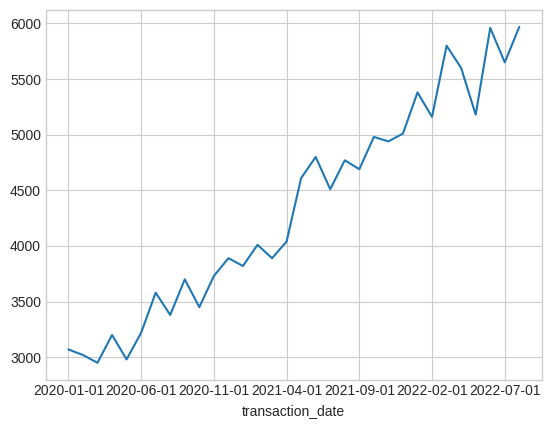

In [ ]:
df5[df5['transaction_type']=='initial'].groupby('transaction_date')['Count'].sum().plot(kind='line')

In [ ]:
df5[df5['Churn_Date']!='2050-01-01'].groupby('Churn_Date')['Count'].sum().plot(kind='line')

<Axes: xlabel='Churn_Date'>

In [ ]:
import matplotlib.pyplot as plt

# Filter and group data based on the conditions
initial_transactions = df5[(df5['transaction_type']=='initial') & (df5['Upgraded']=='nan') & (df5['Downgraded']=='nan')].groupby('transaction_date')['Count'].sum()
churn_transactions = df5[df5['Churn_Date']!='2050-01-01'].groupby('Churn_Date')['Count'].sum()

# Plotting the two conditions on the same graph
plt.figure(figsize=(10, 6))
plt.plot(initial_transactions.index, initial_transactions.values, label='Initial Transactions')
plt.plot(churn_transactions.index, churn_transactions.values, label='Churn Transactions')

# Adding titles and labels
plt.title('Initial Transactions vs. Churn Transactions Over Time')
plt.xlabel('Date')
plt.ylabel('Count of Subscribers')
plt.legend()

# Display the plot
plt.show()

<Figure size 1000x600 with 0 Axes>

Text(0.5, 1.0, 'Initial Transactions vs. Churn Transactions Over Time')

Text(0.5, 0, 'Date')

Text(0, 0.5, 'Count of Subscribers')

Now setting the pivot chart, which has transaction date as the y axis and the Churn Date as the x-axis

In [ ]:
pivot_1 = df5.reset_index().pivot_table(values='Count', index='transaction_date', columns='Churn_Date', aggfunc='sum')
pivot_1 = pivot_1.reset_index()

In [ ]:
pivot_1

Churn_Date transaction_date  2020-02-01  2020-03-01  2020-04-01  2020-05-01  \
0                2020-01-01          90          40          70         100   
1                2020-02-01         NaN          70          10          60   
2                2020-03-01         NaN         NaN          30          60   
3                2020-04-01         NaN         NaN         NaN          70   
4                2020-05-01         NaN         NaN         NaN         NaN   
5                2020-06-01         NaN         NaN         NaN         NaN   
6                2020-07-01         NaN         NaN         NaN         NaN   
7                2020-08-01         NaN         NaN         NaN         NaN   
8                2020-09-01         NaN         NaN         NaN         NaN   
9                2020-10-01         NaN         NaN         NaN         NaN   
10               2020-11-01         NaN         NaN         NaN         NaN   
11               2020-12-01         NaN         NaN         NaN         NaN   
12               2021-01-01         NaN         NaN         NaN         NaN   
13               2021-02-01         NaN         NaN         NaN         NaN   
14               2021-03-01         NaN         NaN         NaN         NaN   
15               2021-04-01         NaN         NaN         NaN         NaN   
16               2021-05-01         NaN         NaN         NaN         NaN   
17               2021-06-01         NaN         NaN         NaN         NaN   
18               2021-07-01         NaN         NaN         NaN         NaN   
19               2021-08-01         NaN         NaN         NaN         NaN   
20               2021-09-01         NaN         NaN         NaN         NaN   
21               2021-10-01         NaN         NaN         NaN         NaN   
22               2021-11-01         NaN         NaN         NaN         NaN   
23               2021-12-01         NaN         NaN         NaN         NaN   
24               2022-01-01         NaN         NaN         NaN         NaN   
25               2022-02-01         NaN         NaN         NaN         NaN   
26               2022-03-01         NaN         NaN         NaN         NaN   
27               2022-04-01         NaN         NaN         NaN         NaN   
28               2022-05-01         NaN         NaN         NaN         NaN   
29               2022-06-01         NaN         NaN         NaN         NaN   
30               2022-07-01         NaN         NaN         NaN         NaN   
31               2022-08-01         NaN         NaN         NaN         NaN   

Churn_Date  2020-06-01  2020-07-01  2020-08-01  2020-09-01  2020-10-01  \
0                  130         120          70          30          40   
1                   50          90          60          90          90   
2                   50          60          30          70          50   
3                   60          60          30          20          80   
4                   70          80          70          80          40   
5                  NaN          60          50          80          70   
6                  NaN         NaN         110          40         110   
7                  NaN         NaN         NaN          10          50   
8                  NaN         NaN         NaN         NaN          30   
9                  NaN         NaN         NaN         NaN         NaN   
10                 NaN         NaN         NaN         NaN         NaN   
11                 NaN         NaN         NaN         NaN         NaN   
12                 NaN         NaN         NaN         NaN         NaN   
13                 NaN         NaN         NaN         NaN         NaN   
14                 NaN         NaN         NaN         NaN         NaN   
15                 NaN         NaN         NaN         NaN         NaN   
16                 NaN         NaN         NaN         NaN         NaN   
17                 NaN         NaN         NaN         NaN  

In [ ]:
cumsum_pivot

Churn_Date transaction_date  2020-02-01  2020-03-01  2020-04-01  2020-05-01  \
0                2020-01-01          90         130         200         300   
1                2020-02-01         NaN          70          80         140   
2                2020-03-01         NaN         NaN          30          90   
3                2020-04-01         NaN         NaN         NaN          70   
4                2020-05-01         NaN         NaN         NaN         NaN   
5                2020-06-01         NaN         NaN         NaN         NaN   
6                2020-07-01         NaN         NaN         NaN         NaN   
7                2020-08-01         NaN         NaN         NaN         NaN   
8                2020-09-01         NaN         NaN         NaN         NaN   
9                2020-10-01         NaN         NaN         NaN         NaN   
10               2020-11-01         NaN         NaN         NaN         NaN   
11               2020-12-01         NaN         NaN         NaN         NaN   
12               2021-01-01         NaN         NaN         NaN         NaN   
13               2021-02-01         NaN         NaN         NaN         NaN   
14               2021-03-01         NaN         NaN         NaN         NaN   
15               2021-04-01         NaN         NaN         NaN         NaN   
16               2021-05-01         NaN         NaN         NaN         NaN   
17               2021-06-01         NaN         NaN         NaN         NaN   
18               2021-07-01         NaN         NaN         NaN         NaN   
19               2021-08-01         NaN         NaN         NaN         NaN   
20               2021-09-01         NaN         NaN         NaN         NaN   
21               2021-10-01         NaN         NaN         NaN         NaN   
22               2021-11-01         NaN         NaN         NaN         NaN   
23               2021-12-01         NaN         NaN         NaN         NaN   
24               2022-01-01         NaN         NaN         NaN         NaN   
25               2022-02-01         NaN         NaN         NaN         NaN   
26               2022-03-01         NaN         NaN         NaN         NaN   
27               2022-04-01         NaN         NaN         NaN         NaN   
28               2022-05-01         NaN         NaN         NaN         NaN   
29               2022-06-01         NaN         NaN         NaN         NaN   
30               2022-07-01         NaN         NaN         NaN         NaN   
31               2022-08-01         NaN         NaN         NaN         NaN   

Churn_Date  2020-06-01  2020-07-01  2020-08-01  2020-09-01  2020-10-01  \
0                  430         550         620         650         690   
1                  190         280         340         430         520   
2                  140         200         230         300         350   
3                  130         190         220         240         320   
4                   70         150         220         300         340   
5                  NaN          60         110         190         260   
6                  NaN         NaN         110         150         260   
7                  NaN         NaN         NaN          10          60   
8                  NaN         NaN         NaN         NaN          30   
9                  NaN         NaN         NaN         NaN         NaN   
10                 NaN         NaN         NaN         NaN         NaN   
11                 NaN         NaN         NaN         NaN         NaN   
12                 NaN         NaN         NaN         NaN         NaN   
13                 NaN         NaN         NaN         NaN         NaN   
14                 NaN         NaN         NaN         NaN         NaN   
15                 NaN         NaN         NaN         NaN         NaN   
16                 NaN         NaN         NaN         NaN         NaN   
17                 NaN         NaN         NaN         NaN  

This allows us to look at the cumulative churn count across each row. That makes it so that when we divide to find the retention, we are easily able to gather the retention rate

In [ ]:
cumsum_pivot = pivot_1.iloc[:, 1:].cumsum(axis=1)

# Add the 'transaction_date' column back to the cumsum DataFrame
cumsum_pivot.insert(0, 'transaction_date', pivot_1['transaction_date'])

In [ ]:
df_cumsum = df5.groupby('transaction_date')['Count'].sum().reset_index()
df_cumsum['Subscriber Count'] = df_cumsum['Count'].cumsum()
df_cumsum.drop(columns='Count', inplace=True)

In [ ]:
cumsum_pivot

Churn_Date transaction_date  2020-02-01  2020-03-01  2020-04-01  2020-05-01  \
0                2020-01-01          90         130         200         300   
1                2020-02-01         NaN          70          80         140   
2                2020-03-01         NaN         NaN          30          90   
3                2020-04-01         NaN         NaN         NaN          70   
4                2020-05-01         NaN         NaN         NaN         NaN   
5                2020-06-01         NaN         NaN         NaN         NaN   
6                2020-07-01         NaN         NaN         NaN         NaN   
7                2020-08-01         NaN         NaN         NaN         NaN   
8                2020-09-01         NaN         NaN         NaN         NaN   
9                2020-10-01         NaN         NaN         NaN         NaN   
10               2020-11-01         NaN         NaN         NaN         NaN   
11               2020-12-01         NaN         NaN         NaN         NaN   
12               2021-01-01         NaN         NaN         NaN         NaN   
13               2021-02-01         NaN         NaN         NaN         NaN   
14               2021-03-01         NaN         NaN         NaN         NaN   
15               2021-04-01         NaN         NaN         NaN         NaN   
16               2021-05-01         NaN         NaN         NaN         NaN   
17               2021-06-01         NaN         NaN         NaN         NaN   
18               2021-07-01         NaN         NaN         NaN         NaN   
19               2021-08-01         NaN         NaN         NaN         NaN   
20               2021-09-01         NaN         NaN         NaN         NaN   
21               2021-10-01         NaN         NaN         NaN         NaN   
22               2021-11-01         NaN         NaN         NaN         NaN   
23               2021-12-01         NaN         NaN         NaN         NaN   
24               2022-01-01         NaN         NaN         NaN         NaN   
25               2022-02-01         NaN         NaN         NaN         NaN   
26               2022-03-01         NaN         NaN         NaN         NaN   
27               2022-04-01         NaN         NaN         NaN         NaN   
28               2022-05-01         NaN         NaN         NaN         NaN   
29               2022-06-01         NaN         NaN         NaN         NaN   
30               2022-07-01         NaN         NaN         NaN         NaN   
31               2022-08-01         NaN         NaN         NaN         NaN   

Churn_Date  2020-06-01  2020-07-01  2020-08-01  2020-09-01  2020-10-01  \
0                  430         550         620         650         690   
1                  190         280         340         430         520   
2                  140         200         230         300         350   
3                  130         190         220         240         320   
4                   70         150         220         300         340   
5                  NaN          60         110         190         260   
6                  NaN         NaN         110         150         260   
7                  NaN         NaN         NaN          10          60   
8                  NaN         NaN         NaN         NaN          30   
9                  NaN         NaN         NaN         NaN         NaN   
10                 NaN         NaN         NaN         NaN         NaN   
11                 NaN         NaN         NaN         NaN         NaN   
12                 NaN         NaN         NaN         NaN         NaN   
13                 NaN         NaN         NaN         NaN         NaN   
14                 NaN         NaN         NaN         NaN         NaN   
15                 NaN         NaN         NaN         NaN         NaN   
16                 NaN         NaN         NaN         NaN         NaN   
17                 NaN         NaN         NaN         NaN  

Creating a cumulative number of acquisitions column and then definiting the retention rates function. Note that the row.index will take away the initial date and result and include up to the active column. This will change depending on the dataset. We are now creating a new column for the Retention Rate value for the duration of time. If there is too much data on retention rates, we could make a column that is +24 month retention rate

In [ ]:
# Automatically identify the rightmost column as the active instances column
active_column = cumsum_pivot.columns[-1]  # assuming the last column is 'Result' and the second to last is the active instances

cumsum_pivot['Cumulative Number of Acquisitions'] = df_cumsum['Subscriber Count']

# Function to calculate retention rates. rates is an empty dictionary to store retention rates. Active_value represents the initial subscriber count at the start of the period
def calculate_retention_rates(row):
    rates = {}
    active_value = row[active_column]

    # Iterate over the columns except 'Initial Date', 'Result', and the active column
    retention_count = 1
    for col in row.index[1:-2]:  # Skip 'Initial Date', 'Result', and include up to the active column
        if pd.notna(row[col]):
            rate_column_name = f"{retention_count} Month Retention Rate"
            rates[rate_column_name] = 1 - (row[col] / active_value)
            retention_count += 1

    return pd.Series(rates)

# Apply the function to each row and create new columns with retention rates
retention_rates_df = cumsum_pivot.apply(calculate_retention_rates, axis=1)

# Concatenate the retention rates DataFrame with the original DataFrame
pivot_2 = pd.concat([cumsum_pivot, retention_rates_df], axis=1)

# Extract retention columns and sort them by the numeric part of the header

retention_columns = sorted(
    [col for col in pivot_2.columns if isinstance(col, str) and 'Month Retention Rate' in col],
    key=lambda x: int(x.split()[0])
)
# Reorder the DataFrame columns
pivot_2 = pivot_2[cumsum_pivot.columns.tolist() + retention_columns]

#pivot_2.iloc[:, -11:] = pivot_2.iloc[:, -11:].apply(lambda x: x.apply(lambda y: f"{y:.2f}" if pd.notna(y) else y))

In [ ]:
pivot_2['11 Month Retention Rate'].max()

0.8534704370179949

In [ ]:
pivot_2['11 Month Retention Rate'].min()

0.7263843648208469

In [ ]:
# Select columns that end with 'Month Retention Rate'
retention_columns = [col for col in pivot_2.columns if isinstance(col, str) and col.endswith('Month Retention Rate')]

# Calculate the average for each of these columns
average_values = pivot_2[retention_columns].mean()

<Figure size 1000x600 with 0 Axes>

<Axes: >

Text(0, 0.5, 'Average Value')

Text(0.5, 1.0, 'Average of Month Retention Rates')

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 [Text(0, 0, '1 Month Retention Rate'),
  Text(1, 0, '2 Month Retention Rate'),
  Text(2, 0, '3 Month Retention Rate'),
  Text(3, 0, '4 Month Retention Rate'),
  Text(4, 0, '5 Month Retention Rate'),
  Text(5, 0, '6 Month Retention Rate'),
  Text(6, 0, '7 Month Retention Rate'),
  Text(7, 0, '8 Month Retention Rate'),
  Text(8, 0, '9 Month Retention Rate'),
  Text(9, 0, '10 Month Retention Rate'),
  Text(10, 0, '11 Month Retention Rate')])

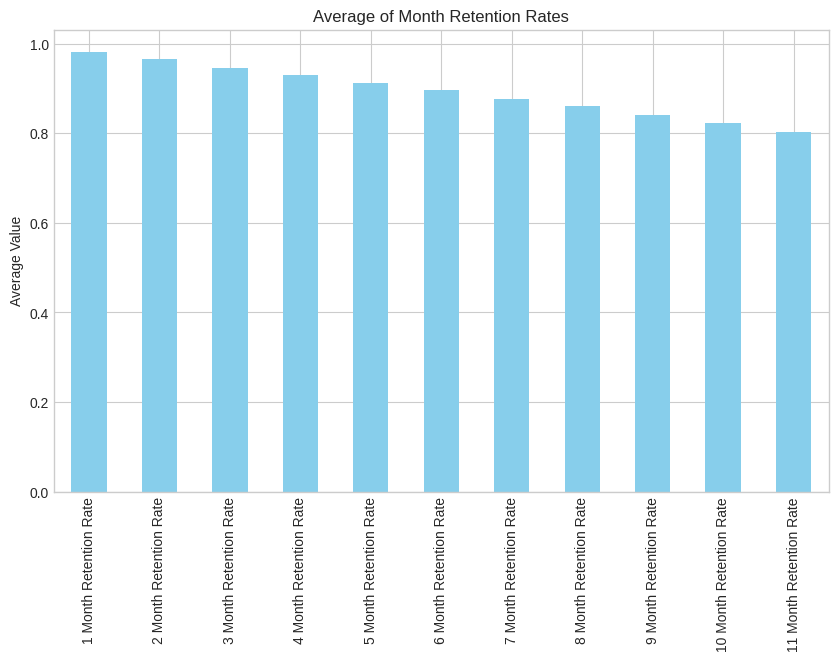

In [ ]:
plt.figure(figsize=(10, 6))
average_values.plot(kind='bar', color='skyblue')

# Add labels and title
plt.ylabel('Average Value')
plt.title('Average of Month Retention Rates')

# Display the plot
plt.xticks(rotation=90)
plt.show()

In [ ]:
!pip install nixtla

#Install nixtlats
!pip install nixtlats>=0.1.0

from nixtla import NixtlaClient
nixtla_client = NixtlaClient(
    api_key = 'nixtla-tok-f56VIMrwjSxpDofdY6iCcCjSVLnbeTnrf84W2hGfYVYBTcF3iSkIz6QZ8uEKzV6WPc8Wnjri5VroN6Ph'
)

#Install statsforecast
!pip install statsforecast

#Install mlforecast.
#This will also install collected packages: window-ops, utilsforecast, mlforecast
!pip install mlforecast

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from numba import njit
#from window_ops.expanding import expanding_mean
#from window_ops.rolling import rolling_mean
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from nixtlats import TimeGPT

/usr/local/lib/python3.11/dist-packages/nixtlats/__init__.py:5: FutureWarning: This package is deprecated, please install nixtla instead.
  warnings.warn("This package is deprecated, please install nixtla instead.", category=FutureWarning)


In [ ]:
nixtla_client.validate_api_key()

True

In [ ]:
import os

os.environ['NIXTLA_API_KEY'] = "nixtla-tok-f56VIMrwjSxpDofdY6iCcCjSVLnbeTnrf84W2hGfYVYBTcF3iSkIz6QZ8uEKzV6WPc8Wnjri5VroN6Ph"

# Initialize the NixtlaClient with the API key
timegpt = NixtlaClient(api_key=os.environ['NIXTLA_API_KEY'])

In [ ]:
# Ensure 'transaction_date' is converted to datetime, coercing any errors
#pivot_2['transaction_date'] = pd.to_datetime(pivot_2['transaction_date'], errors='coerce')
from datetime import datetime

#pivot_2['transaction_date'] = pivot_2['transaction_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())

pivot_2['transaction_date'] = pd.to_datetime(pivot_2['transaction_date'], errors='coerce')

# Check for any remaining non-datetime values
if pivot_2['transaction_date'].isnull().any():
    print("Warning: Some dates could not be converted and are set to NaT")

# Optionally: Drop rows with NaT in 'transaction_date'
pivot_2.dropna(subset=['transaction_date'], inplace=True)

# If you want to keep only the date part
pivot_2['transaction_date'] = pivot_2['transaction_date'].dt.date

In [ ]:
# Filter columns ending with 'Retention Rate'
retention_columns = [col for col in pivot_2.columns if isinstance(col, str) and col.endswith('Month Retention Rate')]

# Prepare an empty DataFrame to store the predictions
prediction_df = pd.DataFrame()

# Iterate over each retention rate column
for col in retention_columns:
    # Drop NaN values for modeling
    temp_df = pivot_2[['transaction_date', col]].dropna()

    # Split the data into train and test (assume last value as the test)
    train = temp_df.iloc[:-1]
    test = temp_df.iloc[-1:]

    # Use the timegpt model for forecasting
    timegpt_fcst = timegpt.forecast(df=train, h=12, time_col='transaction_date', target_col=col, freq='M')

    # Extract the forecasted values
    forecast_values = timegpt_fcst['TimeGPT']  # Assuming 'TimeGPT' is the correct column name

    # Prepare a DataFrame for this column's forecast
    col_prediction_df = pd.DataFrame({
        'transaction_date': pd.date_range(start=pivot_2['transaction_date'].max() + pd.DateOffset(months=1), periods=12, freq='M'),
        f'Predicted {col}': forecast_values
    })

    # Merge this column's predictions into the overall prediction_df
    if prediction_df.empty:
        prediction_df = col_prediction_df
    else:
        prediction_df = pd.merge(prediction_df, col_prediction_df, on='transaction_date', how='outer')

/usr/local/lib/python3.11/dist-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/usr/local/lib/python3.11/dist-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/usr/local/lib/python3.11/dist-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
<ipython-input-65-4d36ca43d4bc>:24: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  'transaction_date': pd.date_range(start=pivot_2['transaction_date'].max() + pd.DateOffset(months=1), periods=12, freq='M'),
/usr/local/lib/python3.11/dist-packages/utilsforecast/preprocessing.py:131

You need to merge the Predicted retention rate dataframe back to our pivot table dataframe

In [ ]:
prediction_df['transaction_date'] = pd.to_datetime(prediction_df['transaction_date'])
pivot_2['transaction_date'] = pd.to_datetime(pivot_2['transaction_date'])
pivot_rr = pivot_2.merge(prediction_df, how='outer', on='transaction_date')

Condensing the dataset

In [ ]:
# Define a function to check if a string is a valid date


def is_valid_date(string):
    try:
        pd.to_datetime(string, format='%Y-%m-%d')
        return True
    except ValueError:
        return False

# Filter columns that start with 'transaction_date', are in a valid date format, or start with 'Predicted'
filtered_columns = [col for col in pivot_rr.columns if isinstance(col, str) and col.startswith('transaction_date') or
                    is_valid_date(col) or
                    col.startswith('Predicted')]


# Create a condensed DataFrame with only the filtered columns
condensed_df = pivot_rr[filtered_columns]

We shift the predicted retention rate columns up because, if you think about, for instance,  the Predicted 12 month Retention Rate, then a snapshot that is 11 months prior, we just need to predict one more month and that will be the 'Predicted 12 Month Rate'. So in that case you would need to go up to that snapshot 11 months ago to append the predicted 12 month retention rate

In [ ]:
# List of columns starting from '1 Month Retention Rate'
pred_retention_columns = [col for col in condensed_df.columns if col.endswith('Month Retention Rate')]

# Apply the shifting operation
for i, col in enumerate(pred_retention_columns):
    condensed_df[col] = condensed_df[col].shift(-i)  # Shift each column upward by i rows
condensed_df.replace({None: np.nan}, inplace=True)

<ipython-input-78-a6f57eb29ae2>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  condensed_df[col] = condensed_df[col].shift(-i)  # Shift each column upward by i rows
<ipython-input-78-a6f57eb29ae2>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  condensed_df.replace({None: np.nan}, inplace=True)


In [ ]:
prediction_df

transaction_date Predicted 1 Month Retention Rate  \
0        2022-09-30                             0.99   
1        2022-10-31                             0.98   
2        2022-11-30                             0.98   
3        2022-12-31                             0.98   
4        2023-01-31                             0.98   
5        2023-02-28                             0.98   
6        2023-03-31                             0.98   
7        2023-04-30                             0.98   
8        2023-05-31                             0.98   
9        2023-06-30                             0.98   
10       2023-07-31                             0.98   
11       2023-08-31                             0.98   

   Predicted 2 Month Retention Rate Predicted 3 Month Retention Rate  \
0                              0.96                             0.95   
1                              0.97                             0.94   
2                              0.96                             0.95   
3                              0.96                             0.94   
4                              0.96                             0.94   
5                              0.96                             0.95   
6                              0.97                             0.94   
7                              0.97                             0.95   
8                              0.96                             0.95   
9                              0.96                             0.95   
10                             0.96                             0.94   
11                             0.96                             0.95   

   Predicted 4 Month Retention Rate Predicted 5 Month Retention Rate  \
0                              0.93                             0.92   
1                              0.93                             0.92   
2                              0.92                             0.92   
3                              0.94                             0.92   
4                              0.93                             0.93   
5                              0.92                             0.92   
6                              0.93                             0.92   
7                              0.93                             0.92   
8                              0.93                             0.92   
9                              0.93                             0.93   
10                             0.93                             0.92   
11                             0.92                             0.93   

   Predicted 6 Month Retention Rate Predicted 7 Month Retention Rate  \
0                              0.90                             0.91   
1                              0.90                             0.91   
2                              0.89                             0.91   
3                              0.89                             0.90   
4                              0.89                             0.90   
5                              0.91                             0.90   
6                              0.90                             0.91   
7                              0.89                             0.90   
8                              0.90                             0.90   
9                              0.89                             0.90   
10                             0.90                             0.91   
11                             0.90                             0.91   

   Predicted 8 Month Retention Rate Predicted 9 Month Retention Rate  \
0                              0.88                             0.87   
1                              0.89                             0.87   
2                              0.89                             0.86   
3                              0.89                             0.87   
4                              0.88                             0.86   
5                              

Defines the number of acquisitions column

In [ ]:
acq_columns = df5[df5['transaction_date']!='2050-01-01'].groupby('transaction_date')[['Count']].sum()
acq_columns = acq_columns.reset_index()
acq_columns = acq_columns.rename(columns={'Count':'Acquisitions by Month'})
#acq_columns['transaction_date'] = acq_columns['transaction_date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d').date())
acq_columns['transaction_date'] = pd.to_datetime(acq_columns['transaction_date'])
pivot_aq = pivot_rr.merge(acq_columns, on='transaction_date', how='outer')

In [ ]:
temp_df

transaction_date  Cumulative Number of Acquisitions
0        2020-01-01                               3070
1        2020-02-01                               6090
2        2020-03-01                               9040
3        2020-04-01                              12240
4        2020-05-01                              15220
5        2020-06-01                              18440
6        2020-07-01                              22020
7        2020-08-01                              25400
8        2020-09-01                              29100
9        2020-10-01                              32550
10       2020-11-01                              36280
11       2020-12-01                              40170
12       2021-01-01                              43990
13       2021-02-01                              48000
14       2021-03-01                              51890
15       2021-04-01                              55930
16       2021-05-01                              60540
17       2021-06-01                              65340
18       2021-07-01                              69850
19       2021-08-01                              74620
20       2021-09-01                              79310
21       2021-10-01                              84290
22       2021-11-01                              89230
23       2021-12-01                              94240
24       2022-01-01                              99620
25       2022-02-01                             104780
26       2022-03-01                             110580
27       2022-04-01                             116180
28       2022-05-01                             121360
29       2022-06-01                             127320
30       2022-07-01                             132970
31       2022-08-01                             138940

TimeGPT forecasting for number of acquisitions. h=12 is the number of periods it is forecasting forward

In [ ]:
pivot_3 = pivot_2.copy()
for col in retention_columns:
    # Drop NaN values for modeling
    temp_df2 = pivot_3[['transaction_date', 'Cumulative Number of Acquisitions']].fillna(0)

    # Split the data into train and test (assume last value as the test)
    train2 = temp_df2.iloc[:-1]
    test2 = temp_df2.iloc[-1:]

    # Use the timegpt model for forecasting
    timegpt_fcst2 = timegpt.forecast(df=train2, h=12, time_col='transaction_date', target_col='Cumulative Number of Acquisitions', freq='M')

    # Extract the forecasted values
    forecast_values = timegpt_fcst2['TimeGPT']  # Assuming 'TimeGPT' is the correct column name

    # Prepare a DataFrame for this column's forecast (This will overwrite each loop, keeping the last set of predictions)
    prediction_df3 = pd.DataFrame({
        'transaction_date': pd.date_range(start=pivot_3['transaction_date'].max() + pd.DateOffset(months=1), periods=12, freq='M'),
        'Predicted Acquisition Next 12 Months': forecast_values
    })

/usr/local/lib/python3.11/dist-packages/utilsforecast/preprocessing.py:131: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/usr/local/lib/python3.11/dist-packages/utilsforecast/processing.py:384: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/usr/local/lib/python3.11/dist-packages/utilsforecast/processing.py:440: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
<ipython-input-89-7437ccacfc86>:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  'transaction_date': pd.date_range(start=pivot_3['transaction_date'].max() + pd.DateOffset(months=1), periods=12, freq='M'),
/usr/local/lib/python3.11/dist-packages/utilsforecast/preprocessing.py:131

In [ ]:
pivot_4 = pivot_3.merge(condensed_df, how='outer')

In [ ]:
pivot_5 = pivot_4.merge(prediction_df3, how='outer', on='transaction_date')

This is just a way that we can now create transaction date columns that haven't happened yet. Adjust if we are doing it weekly instead of monthly.

In [ ]:
pivot_6 = pivot_5.copy()
# Assuming pivot_6 is your DataFrame and 'transaction_date' is the date column
# Convert 'transaction_date' to datetime if it is not already in datetime format
pivot_6['transaction_date'] = pd.to_datetime(pivot_6['transaction_date'])

# Find the maximum date in 'transaction_date' column
max_date = pivot_3[pivot_3['transaction_date'] != '2050-01-01']['transaction_date'].max()

# Find the position of the '2050-01-01' column
insert_position = pivot_6.columns.get_loc('2050-01-01')

# Start from the month and year of the max_date
current_year = max_date.year
current_month = max_date.month + 1

# Create columns for the next 11 months, ensuring they are the first day of the month, and fill with NaN
for i in range(1, 12):
    # Manually increment the month and adjust the year if necessary
    next_month = current_month + i
    next_year = current_year + (next_month - 1) // 12
    next_month = (next_month - 1) % 12 + 1

    # Create the date for the first day of the next month
    next_month_date = pd.Timestamp(year=next_year, month=next_month, day=1)

    # Create column name in the format '%Y-%m-%d'
    column_name = next_month_date.strftime('%Y-%m-%d')

    # Insert the column at the desired position with NaN values
    pivot_6.insert(insert_position, column_name, np.nan)

    # Move the insert position right as we insert each new column
    insert_position += 1

In [ ]:
df_aq = df5.groupby('transaction_date')['Count'].sum().reset_index().rename(columns={'Count':'Total Acquisitions'})

In [ ]:
df_aq['transaction_date'] = pd.to_datetime(df_aq['transaction_date'])
pivot_7 = pivot_6.merge(df_aq, how='outer', on='transaction_date')

In [ ]:
date_columns = []
for col in pivot_6.columns:
    try:
        # Check if the column name is a valid date
        if pd.to_datetime(col, format='%Y-%m-%d', errors='raise'):
            if col != '2050-01-01':
                date_columns.append(col)
    except (ValueError, TypeError):
        continue  # Skip columns that are not valid dates

# Find Predicted Retention Rate columns and 'Total Acquisitions' column
predicted_retention_columns = [col for col in pivot_7.columns if 'Predicted' in col and 'Retention Rate' in col]
total_acquisitions_col = 'Total Acquisitions'

# Function to apply the logic to each row
def apply_retention_to_nan(row):
    # Get the Total Acquisitions for this row
    total_acquisitions = row[total_acquisitions_col]

    # Iterate over each Predicted Retention Rate column
    for retention_col in predicted_retention_columns:
        retention_value = row[retention_col]

        # If the retention rate is not NaN, calculate the new value as (1 - retention_value) * Total Acquisitions
        if pd.notna(retention_value):
            calculated_value = (1 - retention_value) * total_acquisitions

            # Find the last non-NaN value in the date columns
            non_nan_positions = row[date_columns].notna().to_numpy().nonzero()[0]
            if len(non_nan_positions) > 0:
                last_non_nan_pos = non_nan_positions[-1]

                # Check if there's a NaN to the right of the last non-NaN value
                if last_non_nan_pos + 1 < len(date_columns):
                    next_nan_pos = last_non_nan_pos + 1
                    # Fill the NaN to the right with the calculated value
                    row[date_columns[next_nan_pos]] = calculated_value

    return row

# Apply the function to each row of the DataFrame
pivot_8 = pivot_7.apply(apply_retention_to_nan, axis=1)

In [ ]:
def convert_to_first_day_of_month(date):
    if date == (date + pd.DateOffset(1)).replace(day=1) - pd.DateOffset(1):
        # If it's the last day of the month, return the first day of the month
        return date.replace(day=1)
    return date

# Apply the function to the 'transaction_date' column
pivot_8['transaction_date'] = pivot_8['transaction_date'].apply(convert_to_first_day_of_month)

In [ ]:
pivot_9 = pivot_8[pivot_8['transaction_date'] > pivot_2['transaction_date'].max()]
predicted_retention_columns = [col for col in pivot_9.columns if 'Predicted' in col or '-01' in col and '2050' not in col or 'transaction_date' in col]
pivot_9 = pivot_9[predicted_retention_columns]

In [ ]:
pivot_9 = pivot_8[pivot_8['transaction_date'] > pivot_2['transaction_date'].max()]
predicted_columns = [col for col in pivot_9.columns if 'Predicted' in col]
pivot_9 = pivot_9[predicted_retention_columns]

Look from this point on. What is needed is the predicted Next 12 Months Acquisition but do it not cumulatively but by row. Then switch the 'nan' value and put it to the front.

In [ ]:
date_string_list = pd.to_datetime(pivot_9['transaction_date']).dt.strftime('%Y-%m-%d').tolist()
end_string_list = date_string_list[1:]

In [ ]:
def get_predicted_values(pivot_9, pivot_1):
    # Find the second last column in pivot_1 (assuming it is a date)
    second_last_column = pivot_1.columns[-2]

    # Convert the second last column to a string for consistency
    second_last_column_str = str(second_last_column)

    # Get the columns in pivot_9 that are after the second last column in pivot_1
    relevant_columns = pivot_9.columns[pivot_9.columns.get_loc(second_last_column_str) + 1:]

    # Filter to only the 'Predicted' columns after the second last date column
    predicted_retention_columns = [col for col in relevant_columns if 'Predicted' in col and 'Retention Rate' in col]

    # Ensure that 'Predicted Acquisition Next 12 Months' exists in the DataFrame
    predicted_acquisition_col = 'Predicted Acquisition Next 12 Months'
    if predicted_acquisition_col not in pivot_9.columns:
        raise KeyError(f"Column '{predicted_acquisition_col}' not found in the DataFrame.")

    # Prepare a list to store the results for each row
    results = []

    # Iterate through each row in the DataFrame
    for row_idx in range(len(pivot_9)):
        current_row = pivot_9.iloc[row_idx]
        predicted_acquisition = current_row[predicted_acquisition_col]

        # Multiply each 'Predicted Retention Rate' by 'Predicted Acquisition Next 12 Months'
        row_result = current_row[predicted_retention_columns] * predicted_acquisition

        # Append the result to the results list
        results.append(row_result.tolist())

    # Convert the results into a DataFrame
    flat_results = pd.DataFrame(results, columns=predicted_retention_columns)

    return flat_results

# Example usage:
# Assuming pivot_9 and pivot_1 contain the relevant columns
predicted_values = get_predicted_values(pivot_9, pivot_1)

In [ ]:
def get_predicted_values(pivot_9, pivot_1):
    # Find the second last column in pivot_1 (assuming it is a date)
    second_last_column = pivot_1.columns[-2]

    # Convert the second last column to a string for consistency
    second_last_column_str = str(second_last_column)

    # Get the columns in pivot_9 that are after the second last column in pivot_1
    relevant_columns = pivot_9.columns[pivot_9.columns.get_loc(second_last_column_str) + 1:]

    # Filter to only the 'Predicted' columns after the second last date column
    predicted_retention_columns = [col for col in relevant_columns if 'Predicted' in col and 'Retention Rate' in col]

    # Ensure that 'Predicted Acquisition Next 12 Months' exists in the DataFrame
    predicted_acquisition_col = 'Predicted Acquisition Next 12 Months'
    if predicted_acquisition_col not in pivot_9.columns:
        raise KeyError(f"Column '{predicted_acquisition_col}' not found in the DataFrame.")

    # Prepare a list to store the results for each row
    results = []

    # Iterate through each row in the DataFrame
    for row_idx in range(len(pivot_9)):
        current_row = pivot_9.iloc[row_idx]
        predicted_acquisition = current_row[predicted_acquisition_col]

        # Multiply only if there is a number in the 'Predicted Retention Rate' column (not NaN)
        row_result = current_row[predicted_retention_columns].apply(
            lambda x: x * predicted_acquisition if pd.notna(x) else np.nan
        )

        # Append the result to the results list
        results.append(row_result.tolist())

    # Convert the results into a DataFrame
    flat_results = pd.DataFrame(results, columns=predicted_retention_columns)

    return flat_results

# Example usage:
# Assuming pivot_9 and pivot_1 contain the relevant columns
predicted_values = get_predicted_values(pivot_9, pivot_1)

In [ ]:
pivot_8

transaction_date  2020-02-01  2020-03-01  2020-04-01  2020-05-01  \
0        2020-01-01          90         130         200         300   
1        2020-02-01         NaN          70          80         140   
2        2020-03-01         NaN         NaN          30          90   
3        2020-04-01         NaN         NaN         NaN          70   
4        2020-05-01         NaN         NaN         NaN         NaN   
5        2020-06-01         NaN         NaN         NaN         NaN   
6        2020-07-01         NaN         NaN         NaN         NaN   
7        2020-08-01         NaN         NaN         NaN         NaN   
8        2020-09-01         NaN         NaN         NaN         NaN   
9        2020-10-01         NaN         NaN         NaN         NaN   
10       2020-11-01         NaN         NaN         NaN         NaN   
11       2020-12-01         NaN         NaN         NaN         NaN   
12       2021-01-01         NaN         NaN         NaN         NaN   
13       2021-02-01         NaN         NaN         NaN         NaN   
14       2021-03-01         NaN         NaN         NaN         NaN   
15       2021-04-01         NaN         NaN         NaN         NaN   
16       2021-05-01         NaN         NaN         NaN         NaN   
17       2021-06-01         NaN         NaN         NaN         NaN   
18       2021-07-01         NaN         NaN         NaN         NaN   
19       2021-08-01         NaN         NaN         NaN         NaN   
20       2021-09-01         NaN         NaN         NaN         NaN   
21       2021-10-01         NaN         NaN         NaN         NaN   
22       2021-11-01         NaN         NaN         NaN         NaN   
23       2021-12-01         NaN         NaN         NaN         NaN   
24       2022-01-01         NaN         NaN         NaN         NaN   
25       2022-02-01         NaN         NaN         NaN         NaN   
26       2022-03-01         NaN         NaN         NaN         NaN   
27       2022-04-01         NaN         NaN         NaN         NaN   
28       2022-05-01         NaN         NaN         NaN         NaN   
29       2022-06-01         NaN         NaN         NaN         NaN   
30       2022-07-01         NaN         NaN         NaN         NaN   
31       2022-08-01         NaN         NaN         NaN         NaN   
32       2022-09-01         NaN         NaN         NaN         NaN   
33       2022-10-01         NaN         NaN         NaN         NaN   
34       2022-11-01         NaN         NaN         NaN         NaN   
35       2022-12-01         NaN         NaN         NaN         NaN   
36       2023-01-01         NaN         NaN         NaN         NaN   
37       2023-02-01         NaN         NaN         NaN         NaN   
38       2023-03-01         NaN         NaN         NaN         NaN   
39       2023-04-01         NaN         NaN         NaN         NaN   
40       2023-05-01         NaN         NaN         NaN         NaN   
41       2023-06-01         NaN         NaN         NaN         NaN   
42       2023-07-01         NaN         NaN         NaN         NaN   
43       2023-08-01         NaN         NaN         NaN         NaN   

    2020-06-01  2020-07-01  2020-08-01  2020-09-01  2020-10-01  2020-11-01  \
0          430         550         620         650         690         780   
1          190         280         340         430         520         600   
2          140         200         230         300         350         380   
3          130         190         220         240         320         360   
4           70         150         220         300         340         400   
5          NaN          60         110         190         260         330   
6          NaN         NaN         110         150         260         320   
7          NaN         NaN         NaN          10          60         100   
8          NaN         NaN         NaN         NaN          30         210   
9          NaN         NaN 

In [ ]:
predicted_values

Predicted 1 Month Retention Rate  Predicted 2 Month Retention Rate  \
0                            139,407                           136,620   
1                            143,107                           139,580   
2                            147,132                           144,210   
3                            152,216                           149,686   
4                            156,793                           154,040   
5                            162,279                           159,477   
6                            166,962                           164,050   
7                            172,264                           168,535   
8                            174,399                           170,959   
9                            179,102                           175,512   
10                           182,386                           179,090   
11                           186,724                               NaN   

    Predicted 3 Month Retention Rate  Predicted 4 Month Retention Rate  \
0                            134,770                           132,462   
1                            137,336                           134,892   
2                            141,853                           139,064   
3                            147,050                           143,961   
4                            150,739                           148,166   
5                            157,069                           153,740   
6                            160,981                           157,877   
7                            166,430                           163,196   
8                            168,581                           164,707   
9                            172,905                               NaN   
10                               NaN                               NaN   
11                               NaN                               NaN   

    Predicted 5 Month Retention Rate  Predicted 6 Month Retention Rate  \
0                            130,940                           127,958   
1                            134,039                           131,082   
2                            137,886                           133,514   
3                            142,987                           139,379   
4                            147,358                           143,083   
5                            152,945                           149,115   
6                            156,869                           152,899   
7                            162,580                               NaN   
8                                NaN                               NaN   
9                                NaN                               NaN   
10                               NaN                               NaN   
11                               NaN                               NaN   

    Predicted 7 Month Retention Rate  Predicted 8 Month Retention Rate  \
0                            127,933                           126,103   
1                            131,655                           129,559   
2                            135,530                           133,802   
3                            140,216                           138,404   
4                            144,870                           143,100   
5                            149,901                               NaN   
6                                NaN                               NaN   
7                                NaN                               NaN   
8                                NaN                               NaN   
9                                NaN                               NaN   
10                               NaN                               NaN   
11                               NaN                               NaN   

    Predicted 9 Month Retention Rate  Predicted 10 Month Retention Rate  \
0                            122,016                            119,200   
1 

In [ ]:
date_string_filter = pd.to_datetime(pivot_9['transaction_date']).tolist()
date_string_filter = [date.strftime('%Y-%m-%d 00:00:00') for date in date_string_filter]
def get_predicted_values(pivot_9, date_string_filter):
    # Check the column names to ensure the correct column name is used
    print("Available columns:", pivot_9.columns)

    # Identify the exact column name for 'Predicted Acquisition Next 12 Months'
    predicted_acquisition_col = 'Predicted Acquisition Next 12 Months'

    # Ensure that the column exists in the DataFrame
    if predicted_acquisition_col not in pivot_9.columns:
        raise KeyError(f"Column '{predicted_acquisition_col}' not found in the DataFrame.")

    # Identify all columns that start with 'Predicted' and are not 'Predicted Acquisition Next 12 Months'
    predicted_retention_columns = [col for col in pivot_9.columns if 'Predicted' in col and col != predicted_acquisition_col]

    # Prepare an empty list to store the results for each row
    results = []

    # Iterate through each row in the DataFrame
    for row_idx in range(len(pivot_9)):
        current_row = pivot_9.iloc[row_idx]
        predicted_acquisition = current_row[predicted_acquisition_col]

        # Get the transaction date for this row
        transaction_date = current_row['transaction_date']

        # Find the index of the transaction_date in the date_string_list
        try:
            start_idx = date_string_filter.index(str(transaction_date))
        except ValueError:
            print(f"Transaction date {transaction_date} not found in date_string_filter")
            continue

        # Multiply each 'Predicted Retention Rate' by the 'Predicted Acquisition Next 12 Months' for this row
        row_result = current_row[predicted_retention_columns] * predicted_acquisition

        # Start filling values from the position defined by start_idx
        # Create a list of NaNs to fill up to the start_idx
        nan_padding = [float('nan')] * start_idx

        # Convert the result to a list and append NaNs for alignment
        aligned_row_result = nan_padding + row_result.tolist()

        # Append the aligned result to the results list
        results.append(aligned_row_result)

    # Convert the results into a flat format (list of arrays), without headers
    flat_results = pd.DataFrame(results).values

    return flat_results

# Example usage:
# Assuming pivot_9 contains the relevant columns and 'date_string_list' is defined
predicted_values = get_predicted_values(pivot_9, date_string_filter)

Available columns: Index(['transaction_date', '2020-02-01', '2020-03-01', '2020-04-01',
       '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01',
       '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01',
       '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01',
       '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01',
       '2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01',
       '2022-06-01', '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01',
       '2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01', '2023-03-01',
       '2023-04-01', '2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01',
       'Predicted 1 Month Retention Rate', 'Predicted 2 Month Retention Rate',
       'Predicted 3 Month Retention Rate', 'Predicted 4 Month Retention Rate',
       'Predicted 5 Month Retention Rate', 'Predicted 6 Month Retention Rate',
       'Predicted 7 Month Retention Rate', 'Predicted 8 Mon

In [ ]:
date_string_filter = pd.to_datetime(pivot_9['transaction_date']).tolist()
date_string_filter = [date.strftime('%Y-%m-%d 00:00:00') for date in date_string_filter]

def get_predicted_values(pivot_9, pivot_1):
    # Find the second last column in pivot_1
    second_last_column = pivot_1.columns[-2]

    # Get the columns in pivot_9 that are after the second last column in pivot_1
    relevant_columns = pivot_9.columns[pivot_9.columns.get_loc(second_last_column) + 1:]

    # Check the column names to ensure the correct column name is used
    print("Available columns after the second last column in pivot_1:", relevant_columns)

    # Identify the exact column name for 'Predicted Acquisition Next 12 Months'
    predicted_acquisition_col = 'Predicted Acquisition Next 12 Months'

    # Ensure that the column exists in the DataFrame
    if predicted_acquisition_col not in pivot_9.columns:
        raise KeyError(f"Column '{predicted_acquisition_col}' not found in the DataFrame.")

    # Identify all columns that start with 'Predicted' and are not 'Predicted Acquisition Next 12 Months'
    predicted_retention_columns = [col for col in relevant_columns if 'Predicted' in col and col != predicted_acquisition_col]

    # Prepare an empty list to store the results for each row
    results = []

    # Iterate through each row in the DataFrame
    for row_idx in range(len(pivot_9)):
        current_row = pivot_9.iloc[row_idx]
        predicted_acquisition = current_row[predicted_acquisition_col]

        # Get the transaction date for this row
        transaction_date = current_row['transaction_date']

        # Find the index of the transaction_date in the relevant columns list
        try:
            start_idx = relevant_columns.get_loc(transaction_date)
        except ValueError:
            print(f"Transaction date {transaction_date} not found in relevant_columns")
            continue

        # Multiply each 'Predicted Retention Rate' by the 'Predicted Acquisition Next 12 Months' for this row
        row_result = current_row[predicted_retention_columns] * predicted_acquisition

        # Start filling values from the position defined by start_idx
        # Create a list of NaNs to fill up to the start_idx
        nan_padding = [float('nan')] * start_idx

        # Convert the result to a list and append NaNs for alignment
        aligned_row_result = nan_padding + row_result.tolist()

        # Append the aligned result to the results list
        results.append(aligned_row_result)

    # Convert the results into a flat format (list of arrays), without headers
    flat_results = pd.DataFrame(results).values

    return flat_results

# Example usage:
# Assuming pivot_9 and pivot_1 contain the relevant columns
predicted_values = get_predicted_values(pivot_9, pivot_1)

Available columns after the second last column in pivot_1: Index(['2022-10-01', '2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01',
       '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01', '2023-07-01',
       '2023-08-01', 'Predicted 1 Month Retention Rate',
       'Predicted 2 Month Retention Rate', 'Predicted 3 Month Retention Rate',
       'Predicted 4 Month Retention Rate', 'Predicted 5 Month Retention Rate',
       'Predicted 6 Month Retention Rate', 'Predicted 7 Month Retention Rate',
       'Predicted 8 Month Retention Rate', 'Predicted 9 Month Retention Rate',
       'Predicted 10 Month Retention Rate',
       'Predicted 11 Month Retention Rate',
       'Predicted Acquisition Next 12 Months'],
      dtype='object')


KeyError: Timestamp('2022-09-01 00:00:00')

In [ ]:
def get_predicted_values(pivot_9, pivot_1):
    # Find the second last column in pivot_1
    second_last_column = pivot_1.columns[-2]

    # Convert the column names to strings for consistent comparison
    second_last_column_str = str(second_last_column)

    # Get the columns in pivot_9 that are after the second last column in pivot_1
    relevant_columns = pivot_9.columns[pivot_9.columns.get_loc(second_last_column_str) + 1:]
    relevant_columns = [pd.to_datetime(col).strftime('%Y-%m-%d') for col in relevant_columns]


    # Check the column names to ensure the correct column name is used
    print("Available columns after the second last column in pivot_1:", relevant_columns)

    # Identify the exact column name for 'Predicted Acquisition Next 12 Months'
    predicted_acquisition_col = 'Predicted Acquisition Next 12 Months'

    # Ensure that the column exists in the DataFrame
    if predicted_acquisition_col not in pivot_9.columns:
        raise KeyError(f"Column '{predicted_acquisition_col}' not found in the DataFrame.")

    # Identify all columns that start with 'Predicted' and are not 'Predicted Acquisition Next 12 Months'
    predicted_retention_columns = [col for col in relevant_columns if 'Predicted' in col and col != predicted_acquisition_col]

    # Prepare an empty list to store the results for each row
    results = []

    # Iterate through each row in the DataFrame
    for row_idx in range(len(pivot_9)):
        current_row = pivot_9.iloc[row_idx]
        predicted_acquisition = current_row[predicted_acquisition_col]

        # Get the transaction date for this row and convert it to a string
        transaction_date = str(current_row['transaction_date'])

        # Find the index of the transaction_date in the relevant columns list
        try:
            start_idx = relevant_columns.get_loc(transaction_date)
        except KeyError:
            print(f"Transaction date {transaction_date} not found in relevant_columns")
            continue

        # Multiply each 'Predicted Retention Rate' by the 'Predicted Acquisition Next 12 Months' for this row
        row_result = current_row[predicted_retention_columns] * predicted_acquisition

        # Start filling values from the position defined by start_idx
        # Create a list of NaNs to fill up to the start_idx
        nan_padding = [float('nan')] * start_idx

        # Convert the result to a list and append NaNs for alignment
        aligned_row_result = nan_padding + row_result.tolist()

        # Append the aligned result to the results list
        results.append(aligned_row_result)

    # Convert the results into a flat format (list of arrays), without headers
    flat_results = pd.DataFrame(results).values

    return flat_results

# Example usage:
# Assuming pivot_9 and pivot_1 contain the relevant columns
predicted_values = get_predicted_values(pivot_9, pivot_1)

DateParseError: Unknown datetime string format, unable to parse: Predicted 1 Month Retention Rate, at position 0

In [ ]:
def get_predicted_values(pivot_9, pivot_1):
    # Find the second last column in pivot_1
    second_last_column = pivot_1.columns[-2]

    # Convert the second last column to a string
    second_last_column_str = str(second_last_column)

    # Get the columns in pivot_9 that are after the second last column in pivot_1
    relevant_columns = pivot_9.columns[pivot_9.columns.get_loc(second_last_column_str) + 1:]

    # Strip the time component only from date-like columns in relevant_columns
    relevant_columns = [
        pd.to_datetime(col).strftime('%Y-%m-%d') if pd.api.types.is_datetime64_any_dtype(pd.to_datetime(col, errors='coerce')) else col
        for col in relevant_columns
    ]

    # Check the column names to ensure the correct column name is used
    print("Available columns after the second last column in pivot_1:", relevant_columns)

    # Identify the exact column name for 'Predicted Acquisition Next 12 Months'
    predicted_acquisition_col = 'Predicted Acquisition Next 12 Months'

    # Ensure that the column exists in the DataFrame
    if predicted_acquisition_col not in pivot_9.columns:
        raise KeyError(f"Column '{predicted_acquisition_col}' not found in the DataFrame.")

    # Identify all columns that start with 'Predicted' and are not 'Predicted Acquisition Next 12 Months'
    predicted_retention_columns = [col for col in relevant_columns if 'Predicted' in col and col != predicted_acquisition_col]

    # Prepare an empty list to store the results for each row
    results = []

    # Iterate through each row in the DataFrame
    for row_idx in range(len(pivot_9)):
        current_row = pivot_9.iloc[row_idx]
        predicted_acquisition = current_row[predicted_acquisition_col]

        # Get the transaction date for this row and convert it to a string in 'YYYY-MM-DD' format
        transaction_date = pd.to_datetime(current_row['transaction_date']).strftime('%Y-%m-%d')

        # Find the index of the transaction_date in the relevant columns list
        try:
            start_idx = relevant_columns.index(transaction_date)
        except ValueError:
            print(f"Transaction date {transaction_date} not found in relevant_columns")
            continue

        # Multiply each 'Predicted Retention Rate' by the 'Predicted Acquisition Next 12 Months' for this row
        row_result = current_row[predicted_retention_columns] * predicted_acquisition

        # Start filling values from the position defined by start_idx
        # Create a list of NaNs to fill up to the start_idx
        nan_padding = [float('nan')] * start_idx

        # Convert the result to a list and append NaNs for alignment
        aligned_row_result = nan_padding + row_result.tolist()

        # Append the aligned result to the results list
        results.append(aligned_row_result)

    # Convert the results into a flat format (list of arrays), without headers
    flat_results = pd.DataFrame(results).values

    return flat_results

# Example usage:
# Assuming pivot_9 and pivot_1 contain the relevant columns
predicted_values = get_predicted_values(pivot_9, pivot_1)

Available columns after the second last column in pivot_1: ['2022-10-01', '2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01', 'Predicted 1 Month Retention Rate', 'Predicted 2 Month Retention Rate', 'Predicted 3 Month Retention Rate', 'Predicted 4 Month Retention Rate', 'Predicted 5 Month Retention Rate', 'Predicted 6 Month Retention Rate', 'Predicted 7 Month Retention Rate', 'Predicted 8 Month Retention Rate', 'Predicted 9 Month Retention Rate', 'Predicted 10 Month Retention Rate', 'Predicted 11 Month Retention Rate', 'Predicted Acquisition Next 12 Months']
Transaction date 2022-09-01 not found in relevant_columns


In [ ]:
pivot_8

transaction_date  2020-02-01  2020-03-01  2020-04-01  2020-05-01  \
0        2020-01-01          90         130         200         300   
1        2020-02-01         NaN          70          80         140   
2        2020-03-01         NaN         NaN          30          90   
3        2020-04-01         NaN         NaN         NaN          70   
4        2020-05-01         NaN         NaN         NaN         NaN   
5        2020-06-01         NaN         NaN         NaN         NaN   
6        2020-07-01         NaN         NaN         NaN         NaN   
7        2020-08-01         NaN         NaN         NaN         NaN   
8        2020-09-01         NaN         NaN         NaN         NaN   
9        2020-10-01         NaN         NaN         NaN         NaN   
10       2020-11-01         NaN         NaN         NaN         NaN   
11       2020-12-01         NaN         NaN         NaN         NaN   
12       2021-01-01         NaN         NaN         NaN         NaN   
13       2021-02-01         NaN         NaN         NaN         NaN   
14       2021-03-01         NaN         NaN         NaN         NaN   
15       2021-04-01         NaN         NaN         NaN         NaN   
16       2021-05-01         NaN         NaN         NaN         NaN   
17       2021-06-01         NaN         NaN         NaN         NaN   
18       2021-07-01         NaN         NaN         NaN         NaN   
19       2021-08-01         NaN         NaN         NaN         NaN   
20       2021-09-01         NaN         NaN         NaN         NaN   
21       2021-10-01         NaN         NaN         NaN         NaN   
22       2021-11-01         NaN         NaN         NaN         NaN   
23       2021-12-01         NaN         NaN         NaN         NaN   
24       2022-01-01         NaN         NaN         NaN         NaN   
25       2022-02-01         NaN         NaN         NaN         NaN   
26       2022-03-01         NaN         NaN         NaN         NaN   
27       2022-04-01         NaN         NaN         NaN         NaN   
28       2022-05-01         NaN         NaN         NaN         NaN   
29       2022-06-01         NaN         NaN         NaN         NaN   
30       2022-07-01         NaN         NaN         NaN         NaN   
31       2022-08-01         NaN         NaN         NaN         NaN   
32       2022-09-01         NaN         NaN         NaN         NaN   
33       2022-10-01         NaN         NaN         NaN         NaN   
34       2022-11-01         NaN         NaN         NaN         NaN   
35       2022-12-01         NaN         NaN         NaN         NaN   
36       2023-01-01         NaN         NaN         NaN         NaN   
37       2023-02-01         NaN         NaN         NaN         NaN   
38       2023-03-01         NaN         NaN         NaN         NaN   
39       2023-04-01         NaN         NaN         NaN         NaN   
40       2023-05-01         NaN         NaN         NaN         NaN   
41       2023-06-01         NaN         NaN         NaN         NaN   
42       2023-07-01         NaN         NaN         NaN         NaN   
43       2023-08-01         NaN         NaN         NaN         NaN   

    2020-06-01  2020-07-01  2020-08-01  2020-09-01  2020-10-01  2020-11-01  \
0          430         550         620         650         690         780   
1          190         280         340         430         520         600   
2          140         200         230         300         350         380   
3          130         190         220         240         320         360   
4           70         150         220         300         340         400   
5          NaN          60         110         190         260         330   
6          NaN         NaN         110         150         260         320   
7          NaN         NaN         NaN          10          60         100   
8          NaN         NaN         NaN         NaN          30         210   
9          NaN         NaN 

In [ ]:
pivot_8[pivot_8['transaction_date']=='2022-10-01']['Predicted 1 Month Retention Rate'].unique()

array([0.98263758])

In [ ]:
0.98263758 *

In [ ]:
predicted_values

array([[143106.60882089, 139579.74273414, 137336.3543065 ,
        134892.4195107 , 134038.62826566, 131082.47254214,
        131654.72804036, 129559.00417009, 125584.77810282,
        121327.09789079, 119121.5479092 ,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan],
       [            nan, 147132.0194134 , 144210.0471264 ,
        141853.12233749, 139064.03589936, 137886.12532662,
        133514.20781692, 135529.86451832, 133802.37540114,
        128490.63820322, 124781.93862189,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan],
       [            nan,             nan, 152215.78994264,
        149686.31584971, 147050.38639032, 143960.62138302,
        142986.84224647, 139378.73789952, 140216.43406

In [ ]:
date_string_filter = pd.to_datetime(pivot_9['transaction_date']).tolist()
date_string_filter = [date.strftime('%Y-%m-%d 00:00:00') for date in date_string_filter]
def get_predicted_values(pivot_9, date_string_filter):
    # Check the column names to ensure the correct column name is used
    print("Available columns:", pivot_9.columns)

    # Identify the exact column name for 'Predicted Acquisition Next 12 Months'
    predicted_acquisition_col = 'Predicted Acquisition Next 12 Months'

    # Ensure that the column exists in the DataFrame
    if predicted_acquisition_col not in pivot_9.columns:
        raise KeyError(f"Column '{predicted_acquisition_col}' not found in the DataFrame.")

    # Identify all columns that start with 'Predicted' and are not 'Predicted Acquisition Next 12 Months'
    predicted_retention_columns = [col for col in pivot_9.columns if 'Predicted' in col and col != predicted_acquisition_col]

    # Prepare an empty list to store the results for each row
    results = []

    # Iterate through each row in the DataFrame
    def process_after_transaction_date(pivot_9, pivot_1, predicted_acquisition_col):
    # Get the index of the 'transaction_date' column in pivot_1
      transaction_date_idx = pivot_1.columns.get_loc('transaction_date')

    # Start iterating from the length of columns after 'transaction_date'
      for row_idx in range(transaction_date_idx + 1, len(pivot_9)):
        current_row = pivot_9.iloc[row_idx]
        predicted_acquisition = current_row[predicted_acquisition_col]

        # Get the transaction date for this row
        transaction_date = current_row['transaction_date']

        # Find the index of the transaction_date in the date_string_list
        try:
            start_idx = date_string_filter.index(str(transaction_date))
        except ValueError:
            print(f"Transaction date {transaction_date} not found in date_string_filter")
            continue

        # Multiply each 'Predicted Retention Rate' by the 'Predicted Acquisition Next 12 Months' for this row
        row_result = current_row[predicted_retention_columns] * predicted_acquisition

        # Start filling values from the position defined by start_idx
        # Create a list of NaNs to fill up to the start_idx
        nan_padding = [float('nan')] * start_idx

        # Convert the result to a list and append NaNs for alignment
        aligned_row_result = nan_padding + row_result.tolist()

        # Append the aligned result to the results list
        results.append(aligned_row_result)

    # Convert the results into a flat format (list of arrays), without headers
    flat_results = pd.DataFrame(results).values

    return flat_results

# Example usage:
# Assuming pivot_9 contains the relevant columns and 'date_string_list' is defined
predicted_values = get_predicted_values(pivot_9, date_string_filter)

Available columns: Index(['transaction_date', '2020-02-01', '2020-03-01', '2020-04-01',
       '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01',
       '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01',
       '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01',
       '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01',
       '2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01',
       '2022-06-01', '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01',
       '2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01', '2023-03-01',
       '2023-04-01', '2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01',
       'Predicted 1 Month Retention Rate', 'Predicted 2 Month Retention Rate',
       'Predicted 3 Month Retention Rate', 'Predicted 4 Month Retention Rate',
       'Predicted 5 Month Retention Rate', 'Predicted 6 Month Retention Rate',
       'Predicted 7 Month Retention Rate', 'Predicted 8 Mon

In [ ]:
predicted_values

array([], shape=(0, 0), dtype=float64)

In [ ]:
pivot_1

Churn_Date transaction_date  2020-02-01  2020-03-01  2020-04-01  2020-05-01  \
0                2020-01-01          90          40          70         100   
1                2020-02-01         NaN          70          10          60   
2                2020-03-01         NaN         NaN          30          60   
3                2020-04-01         NaN         NaN         NaN          70   
4                2020-05-01         NaN         NaN         NaN         NaN   
5                2020-06-01         NaN         NaN         NaN         NaN   
6                2020-07-01         NaN         NaN         NaN         NaN   
7                2020-08-01         NaN         NaN         NaN         NaN   
8                2020-09-01         NaN         NaN         NaN         NaN   
9                2020-10-01         NaN         NaN         NaN         NaN   
10               2020-11-01         NaN         NaN         NaN         NaN   
11               2020-12-01         NaN         NaN         NaN         NaN   
12               2021-01-01         NaN         NaN         NaN         NaN   
13               2021-02-01         NaN         NaN         NaN         NaN   
14               2021-03-01         NaN         NaN         NaN         NaN   
15               2021-04-01         NaN         NaN         NaN         NaN   
16               2021-05-01         NaN         NaN         NaN         NaN   
17               2021-06-01         NaN         NaN         NaN         NaN   
18               2021-07-01         NaN         NaN         NaN         NaN   
19               2021-08-01         NaN         NaN         NaN         NaN   
20               2021-09-01         NaN         NaN         NaN         NaN   
21               2021-10-01         NaN         NaN         NaN         NaN   
22               2021-11-01         NaN         NaN         NaN         NaN   
23               2021-12-01         NaN         NaN         NaN         NaN   
24               2022-01-01         NaN         NaN         NaN         NaN   
25               2022-02-01         NaN         NaN         NaN         NaN   
26               2022-03-01         NaN         NaN         NaN         NaN   
27               2022-04-01         NaN         NaN         NaN         NaN   
28               2022-05-01         NaN         NaN         NaN         NaN   
29               2022-06-01         NaN         NaN         NaN         NaN   
30               2022-07-01         NaN         NaN         NaN         NaN   
31               2022-08-01         NaN         NaN         NaN         NaN   

Churn_Date  2020-06-01  2020-07-01  2020-08-01  2020-09-01  2020-10-01  \
0                  130         120          70          30          40   
1                   50          90          60          90          90   
2                   50          60          30          70          50   
3                   60          60          30          20          80   
4                   70          80          70          80          40   
5                  NaN          60          50          80          70   
6                  NaN         NaN         110          40         110   
7                  NaN         NaN         NaN          10          50   
8                  NaN         NaN         NaN         NaN          30   
9                  NaN         NaN         NaN         NaN         NaN   
10                 NaN         NaN         NaN         NaN         NaN   
11                 NaN         NaN         NaN         NaN         NaN   
12                 NaN         NaN         NaN         NaN         NaN   
13                 NaN         NaN         NaN         NaN         NaN   
14                 NaN         NaN         NaN         NaN         NaN   
15                 NaN         NaN         NaN         NaN         NaN   
16                 NaN         NaN         NaN         NaN         NaN   
17                 NaN         NaN         NaN         NaN  

In [ ]:
predicted_values

array([[139406.70158997, 136620.01313414, 134770.20599668,
        132461.84499725, 130940.03551276, 127958.34575867,
        127933.06921498, 126103.01042907, 122015.74956038,
        119199.72887042, 117069.0693777 ,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan],
       [            nan, 143106.60882089, 139579.74273414,
        137336.3543065 , 134892.4195107 , 134038.62826566,
        131082.47254214, 131654.72804036, 129559.00417009,
        125584.77810282, 121327.09789079, 119121.5479092 ,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan,             nan,             nan,
                    nan],
       [            nan,             nan, 147132.0194134 ,
        144210.0471264 , 141853.12233749, 139064.03589936,
    

In [ ]:
date_string_filter

['2022-09-01 00:00:00',
 '2022-10-01 00:00:00',
 '2022-11-01 00:00:00',
 '2022-12-01 00:00:00',
 '2023-01-01 00:00:00',
 '2023-02-01 00:00:00',
 '2023-03-01 00:00:00',
 '2023-04-01 00:00:00',
 '2023-05-01 00:00:00',
 '2023-06-01 00:00:00',
 '2023-07-01 00:00:00',
 '2023-08-01 00:00:00']

In [ ]:
pivot_8

transaction_date  2020-02-01  2020-03-01  2020-04-01  2020-05-01  \
0        2020-01-01          90         130         200         300   
1        2020-02-01         NaN          70          80         140   
2        2020-03-01         NaN         NaN          30          90   
3        2020-04-01         NaN         NaN         NaN          70   
4        2020-05-01         NaN         NaN         NaN         NaN   
5        2020-06-01         NaN         NaN         NaN         NaN   
6        2020-07-01         NaN         NaN         NaN         NaN   
7        2020-08-01         NaN         NaN         NaN         NaN   
8        2020-09-01         NaN         NaN         NaN         NaN   
9        2020-10-01         NaN         NaN         NaN         NaN   
10       2020-11-01         NaN         NaN         NaN         NaN   
11       2020-12-01         NaN         NaN         NaN         NaN   
12       2021-01-01         NaN         NaN         NaN         NaN   
13       2021-02-01         NaN         NaN         NaN         NaN   
14       2021-03-01         NaN         NaN         NaN         NaN   
15       2021-04-01         NaN         NaN         NaN         NaN   
16       2021-05-01         NaN         NaN         NaN         NaN   
17       2021-06-01         NaN         NaN         NaN         NaN   
18       2021-07-01         NaN         NaN         NaN         NaN   
19       2021-08-01         NaN         NaN         NaN         NaN   
20       2021-09-01         NaN         NaN         NaN         NaN   
21       2021-10-01         NaN         NaN         NaN         NaN   
22       2021-11-01         NaN         NaN         NaN         NaN   
23       2021-12-01         NaN         NaN         NaN         NaN   
24       2022-01-01         NaN         NaN         NaN         NaN   
25       2022-02-01         NaN         NaN         NaN         NaN   
26       2022-03-01         NaN         NaN         NaN         NaN   
27       2022-04-01         NaN         NaN         NaN         NaN   
28       2022-05-01         NaN         NaN         NaN         NaN   
29       2022-06-01         NaN         NaN         NaN         NaN   
30       2022-07-01         NaN         NaN         NaN         NaN   
31       2022-08-01         NaN         NaN         NaN         NaN   
32       2022-09-01         NaN         NaN         NaN         NaN   
33       2022-10-01         NaN         NaN         NaN         NaN   
34       2022-11-01         NaN         NaN         NaN         NaN   
35       2022-12-01         NaN         NaN         NaN         NaN   
36       2023-01-01         NaN         NaN         NaN         NaN   
37       2023-02-01         NaN         NaN         NaN         NaN   
38       2023-03-01         NaN         NaN         NaN         NaN   
39       2023-04-01         NaN         NaN         NaN         NaN   
40       2023-05-01         NaN         NaN         NaN         NaN   
41       2023-06-01         NaN         NaN         NaN         NaN   
42       2023-07-01         NaN         NaN         NaN         NaN   
43       2023-08-01         NaN         NaN         NaN         NaN   

    2020-06-01  2020-07-01  2020-08-01  2020-09-01  2020-10-01  2020-11-01  \
0          430         550         620         650         690         780   
1          190         280         340         430         520         600   
2          140         200         230         300         350         380   
3          130         190         220         240         320         360   
4           70         150         220         300         340         400   
5          NaN          60         110         190         260         330   
6          NaN         NaN         110         150         260         320   
7          NaN         NaN         NaN          10          60         100   
8          NaN         NaN         NaN         NaN          30         210   
9          NaN         NaN 

In [ ]:
predicted_values

array([[139406.70158997, 136620.01313414, 134770.20599668,
        132461.84499725, 130940.03551276, 127958.34575867,
        127933.06921498, 126103.01042907, 122015.74956038,
        119199.72887042, 117069.0693777 ],
       [143106.60882089, 139579.74273414, 137336.3543065 ,
        134892.4195107 , 134038.62826566, 131082.47254214,
        131654.72804036, 129559.00417009, 125584.77810282,
        121327.09789079, 119121.5479092 ],
       [147132.0194134 , 144210.0471264 , 141853.12233749,
        139064.03589936, 137886.12532662, 133514.20781692,
        135529.86451832, 133802.37540114, 128490.63820322,
        124781.93862189,             nan],
       [152215.78994264, 149686.31584971, 147050.38639032,
        143960.62138302, 142986.84224647, 139378.73789952,
        140216.43406544, 138404.36528358, 134587.57874439,
                    nan,             nan],
       [156792.73595916, 154039.710214  , 150738.57954791,
        148165.7571221 , 147358.23685018, 143083.36174754,
  

In [ ]:
# Ensure retention_rate_columns contains only retention rate columns (e.g., 'Predicted 1 Month Retention Rate', etc.)
retention_rate_columns = [col for col in pivot_9.columns if 'Predicted' in col and 'Retention Rate' in col]

# Define date_columns by checking if the column name contains '-01'
date_columns = [col for col in pivot_9.columns if '-01' in col and col != '2050-01-01']

In [ ]:
# Ensure retention_rate_columns contains only retention rate columns (e.g., 'Predicted 1 Month Retention Rate', etc.)
prediction_columns = [col for col in pivot_9.columns if 'Predicted' in col and 'Retention Rate' in col]

# Define date_columns by checking if the column name contains '-01'
date_columns = [col for col in pivot_9.columns if '-01' in col and col != '2050-01-01']

In [ ]:
def fill_predictions(pivot_9, date_columns, retention_rate_columns, predicted_acquisition_col):
    # Iterate through each row in the DataFrame
    for row_idx in range(len(pivot_9)):
        current_row = pivot_9.iloc[row_idx]
        predicted_acquisition = current_row[predicted_acquisition_col]

        # If 'Predicted Acquisition Next 12 Months' is NaN, skip this row
        if pd.isna(predicted_acquisition):
            print(f"Skipped row {row_idx} due to NaN in 'Predicted Acquisition Next 12 Months'")
            continue

        # Find the position where the date column should start filling (based on the number of non-NaN values in retention rates)
        start_fill_idx = len(retention_rate_columns) - current_row[retention_rate_columns].isna().sum()

        # Iterate through the retention rate columns and date columns starting at the correct position
        for j, (retention_col, date_col) in enumerate(zip(retention_rate_columns, date_columns[start_fill_idx:]), start=start_fill_idx):
            # Check if the current retention rate column has a valid numeric value
            retention_rate = current_row[retention_col]

            if pd.api.types.is_numeric_dtype(type(retention_rate)) and pd.notna(retention_rate):
                # Calculate the value to fill based on the retention rate and predicted acquisition
                value_to_fill = retention_rate * predicted_acquisition

                # Fill the value in the appropriate date column
                pivot_9.at[row_idx, date_col] = value_to_fill

                # Debugging statement (optional)
                print(f"Filled value {value_to_fill} at row {row_idx}, column {date_col}")
            else:
                print(f"Skipped retention column {retention_col} in row {row_idx} due to non-numeric value")

    return pivot_9

In [ ]:
def fill_predictions(pivot_9, date_columns, retention_rate_columns, predicted_acquisition_col, start_transaction_date):
    # Start processing from the specified transaction_date
    start_row_idx = pivot_9[pivot_9['transaction_date'] == start_transaction_date].index[0]

    # Iterate through each row in the DataFrame starting from the specified transaction_date
    for row_idx in range(start_row_idx, len(pivot_9)):
        current_row = pivot_9.iloc[row_idx]
        predicted_acquisition = current_row[predicted_acquisition_col]

        # If 'Predicted Acquisition Next 12 Months' is NaN, skip this row
        if pd.isna(predicted_acquisition):
            print(f"Skipped row {row_idx} due to NaN in 'Predicted Acquisition Next 12 Months'")
            continue

        # Find the number of `1`s in the predicted retention rate columns
        num_non_na_ones = (current_row[retention_rate_columns] == 1).sum()

        # Start filling at the column position equal to the number of non-NaN 1s
        start_fill_idx = num_non_na_ones

        # Ensure that the starting index does not exceed the number of date columns
        if start_fill_idx >= len(date_columns):
            print(f"Row {row_idx} - Start index {start_fill_idx} exceeds the number of date columns")
            continue

        # Iterate through the retention rate columns and date columns starting at the shifted position
        for retention_col, date_col in zip(retention_rate_columns, date_columns[start_fill_idx:]):
            # Check if the current retention rate column has a valid numeric value
            retention_rate = current_row[retention_col]

            # Debugging: Show the retention rate and column being processed
            print(f"Processing row {row_idx}, Retention Rate Column: {retention_col}, Date Column: {date_col}, Retention Rate: {retention_rate}")

            if pd.api.types.is_numeric_dtype(type(retention_rate)) and pd.notna(retention_rate):
                # Calculate the value to fill based on the retention rate and predicted acquisition
                value_to_fill = retention_rate * predicted_acquisition

                # Debugging: Show the calculated value
                print(f"Calculated value to fill: {value_to_fill}")

                # Fill the value in the appropriate date column
                pivot_9.at[row_idx, date_col] = value_to_fill

                # Debugging statement
                print(f"Filled value {value_to_fill} at row {row_idx}, column {date_col}")
            else:
                print(f"Skipped retention column {retention_col} in row {row_idx} due to non-numeric value or NaN")

    return pivot_9

# Example usage:
start_transaction_date = '2022-09-01'  # Define where to start the filling logic
pivot_9_filled = fill_predictions(pivot_9, date_columns, retention_rate_columns, 'Predicted Acquisition Next 12 Months', start_transaction_date)

In [ ]:
pivot_9

transaction_date  2020-02-01  2020-03-01  2020-04-01  2020-05-01  \
32       2022-09-01         NaN         NaN         NaN         NaN   
33       2022-10-01         NaN         NaN         NaN         NaN   
34       2022-11-01         NaN         NaN         NaN         NaN   
35       2022-12-01         NaN         NaN         NaN         NaN   
36       2023-01-01         NaN         NaN         NaN         NaN   
37       2023-02-01         NaN         NaN         NaN         NaN   
38       2023-03-01         NaN         NaN         NaN         NaN   
39       2023-04-01         NaN         NaN         NaN         NaN   
40       2023-05-01         NaN         NaN         NaN         NaN   
41       2023-06-01         NaN         NaN         NaN         NaN   
42       2023-07-01         NaN         NaN         NaN         NaN   
43       2023-08-01         NaN         NaN         NaN         NaN   
0               NaT     139,407     136,620     134,770     132,462   
1               NaT         NaN     143,107     139,580     137,336   
2               NaT         NaN         NaN     147,132     144,210   
3               NaT         NaN         NaN         NaN     152,216   
4               NaT         NaN         NaN         NaN         NaN   
5               NaT         NaN         NaN         NaN         NaN   
6               NaT         NaN         NaN         NaN         NaN   
7               NaT         NaN         NaN         NaN         NaN   
8               NaT         NaN         NaN         NaN         NaN   
9               NaT         NaN         NaN         NaN     179,102   
10              NaT         NaN         NaN     182,386     179,090   
11              NaT         NaN     186,724         NaN         NaN   

    2020-06-01  2020-07-01  2020-08-01  2020-09-01  2020-10-01  2020-11-01  \
32         NaN         NaN         NaN         NaN         NaN         NaN   
33         NaN         NaN         NaN         NaN         NaN         NaN   
34         NaN         NaN         NaN         NaN         NaN         NaN   
35         NaN         NaN         NaN         NaN         NaN         NaN   
36         NaN         NaN         NaN         NaN         NaN         NaN   
37         NaN         NaN         NaN         NaN         NaN         NaN   
38         NaN         NaN         NaN         NaN         NaN         NaN   
39         NaN         NaN         NaN         NaN         NaN         NaN   
40         NaN         NaN         NaN         NaN         NaN         NaN   
41         NaN         NaN         NaN         NaN         NaN         NaN   
42         NaN         NaN         NaN         NaN         NaN         NaN   
43         NaN         NaN         NaN         NaN         NaN         NaN   
0      130,940     127,958     127,933     126,103     122,016     119,200   
1      134,892     134,039     131,082     131,655     129,559     125,585   
2      141,853     139,064     137,886     133,514     135,530     133,802   
3      149,686     147,050     143,961     142,987     139,379     140,216   
4      156,793     154,040     150,739     148,166     147,358     143,083   
5          NaN     162,279     159,477     157,069     153,740     152,945   
6          NaN         NaN     166,962     164,050     160,981     157,877   
7          NaN     172,264     168,535     172,264     168,535     166,430   
8      174,399     170,959     168,581     164,707     174,399     170,959   
9      175,512     172,905         NaN         NaN         NaN     179,102   
10         NaN         NaN         NaN         NaN         NaN         NaN   
11         NaN         NaN         NaN         NaN         NaN         NaN   

    2020-12-01  2021-01-01  2021-02-01  2021-03-01  2021-04-01  2021-05-01  \
32         NaN         NaN         NaN         NaN         NaN         NaN   
33         NaN         NaN         NaN         NaN         NaN         NaN   
34         NaN         NaN         NaN    

In [ ]:
def fill_predictions(pivot_9, date_columns, retention_rate_columns, predicted_acquisition_col):
    # Iterate through each row in the DataFrame
    for row_idx in range(len(pivot_9)):
        current_row = pivot_9.iloc[row_idx]
        predicted_acquisition = current_row[predicted_acquisition_col]

        # If 'Predicted Acquisition Next 12 Months' is NaN, skip this row
        if pd.isna(predicted_acquisition):
            print(f"Skipped row {row_idx} due to NaN in 'Predicted Acquisition Next 12 Months'")
            continue

        # Find the position where the date column should start filling (based on the number of non-NaN values in retention rates)
        start_fill_idx = len(retention_rate_columns) - current_row[retention_rate_columns].isna().sum()

        # Iterate through the retention rate columns and date columns starting at the correct position
        for j, (retention_col, date_col) in enumerate(zip(retention_rate_columns, date_columns[start_fill_idx:]), start=start_fill_idx):
            # Check if the current retention rate column has a valid numeric value
            retention_rate = current_row[retention_col]

            if pd.api.types.is_numeric_dtype(type(retention_rate)) and pd.notna(retention_rate):
                # Calculate the value to fill based on the retention rate and predicted acquisition
                value_to_fill = retention_rate * predicted_acquisition

                # Fill the value in the appropriate date column
                pivot_9.at[row_idx, date_col] = value_to_fill

                # Debugging statement (optional)
                print(f"Filled value {value_to_fill} at row {row_idx}, column {date_col}")
            else:
                print(f"Skipped retention column {retention_col} in row {row_idx} due to non-numeric value")

    return pivot_9

# Example usage:
pivot_9_filled = fill_predictions(pivot_9, date_columns, retention_rate_columns, 'Predicted Acquisition Next 12 Months')

In [ ]:
def fill_predictions(pivot_9, date_columns, retention_rate_columns, predicted_acquisition_col):
    # Iterate through each row in the DataFrame
    for row_idx in range(len(pivot_9)):
        current_row = pivot_9.iloc[row_idx]
        predicted_acquisition = current_row[predicted_acquisition_col]

        # If 'Predicted Acquisition Next 12 Months' is NaN, skip this row
        if pd.isna(predicted_acquisition):
            print(f"Skipped row {row_idx} due to NaN in 'Predicted Acquisition Next 12 Months'")
            continue

        # Find the position where the date column should start filling (based on the number of non-NaN values in retention rates)
        start_fill_idx = len(retention_rate_columns) - current_row[retention_rate_columns].isna().sum()

        # Iterate through the retention rate columns and date columns starting at the correct position
        for j, (retention_col, date_col) in enumerate(zip(retention_rate_columns, date_columns[start_fill_idx:]), start=start_fill_idx):
            # Check if the current retention rate column has a valid numeric value
            retention_rate = current_row[retention_col]

            # Ensure the retention rate is numeric and not a Timestamp or other invalid type
            if pd.api.types.is_numeric_dtype(type(retention_rate)) and pd.notna(retention_rate):
                # Calculate the value to fill based on the retention rate and predicted acquisition
                value_to_fill = retention_rate * predicted_acquisition

                # Fill the value in the appropriate date column
                pivot_9.at[row_idx, date_col] = value_to_fill

                # Debugging statement (optional)
                print(f"Filled value {value_to_fill} at row {row_idx}, column {date_col}")
            else:
                print(f"Skipped retention column {retention_col} in row {row_idx} due to non-numeric value")

    return pivot_9

# Example usage:
# Ensure that date_columns contains only date columns (e.g., ['2020-02-01', '2020-03-01', ...])
# Ensure that retention_rate_columns contains only the retention rate columns (e.g., ['Predicted 1 Month Retention Rate', 'Predicted 2 Month Retention Rate', ...])
# predicted_acquisition_col is the column for 'Predicted Acquisition Next 12 Months'

pivot_9_filled = fill_predictions(pivot_9, date_columns, predicted_retention_columns, 'Predicted Acquisition Next 12 Months')

Skipped retention column transaction_date in row 0 due to non-numeric value
Skipped retention column 2020-02-01 in row 0 due to non-numeric value
Skipped retention column 2020-03-01 in row 0 due to non-numeric value
Skipped retention column 2020-04-01 in row 0 due to non-numeric value
Skipped retention column 2020-05-01 in row 0 due to non-numeric value
Skipped retention column 2020-06-01 in row 0 due to non-numeric value
Skipped retention column 2020-07-01 in row 0 due to non-numeric value
Skipped retention column 2020-08-01 in row 0 due to non-numeric value
Skipped retention column 2020-09-01 in row 0 due to non-numeric value
Skipped retention column 2020-10-01 in row 0 due to non-numeric value
Skipped retention column 2020-11-01 in row 0 due to non-numeric value
Skipped retention column 2020-12-01 in row 0 due to non-numeric value
Skipped retention column 2021-01-01 in row 0 due to non-numeric value
Skipped retention column 2021-02-01 in row 0 due to non-numeric value
Skipped retent

In [ ]:
def fill_predictions(pivot_9, date_columns, retention_rate_columns, predicted_acquisition_col):
    # Iterate through each row in the DataFrame
    for row_idx in range(len(pivot_9)):
        current_row = pivot_9.iloc[row_idx]
        predicted_acquisition = current_row[predicted_acquisition_col]

        # Debugging: Display the predicted acquisition value for the row
        print(f"Row {row_idx} - Predicted Acquisition: {predicted_acquisition}")

        # If 'Predicted Acquisition Next 12 Months' is NaN, skip this row
        if pd.isna(predicted_acquisition):
            print(f"Skipped row {row_idx} due to NaN in 'Predicted Acquisition Next 12 Months'")
            continue

        # Find the position where the date column should start filling (based on the number of non-NaN values in retention rates)
        start_fill_idx = len(retention_rate_columns) - current_row[retention_rate_columns].isna().sum()

        # Debugging: Show where filling starts
        print(f"Row {row_idx} - Starting at column index: {start_fill_idx}, which corresponds to column: {date_columns[start_fill_idx]}")

        # Iterate through the retention rate columns and date columns starting at the correct position
        for j, (retention_col, date_col) in enumerate(zip(retention_rate_columns, date_columns[start_fill_idx:]), start=start_fill_idx):
            # Check if the current retention rate column has a valid numeric value
            retention_rate = current_row[retention_col]

            # Debugging: Show the retention rate and column being processed
            print(f"Processing row {row_idx}, Retention Rate Column: {retention_col}, Date Column: {date_col}, Retention Rate: {retention_rate}")

            if pd.api.types.is_numeric_dtype(type(retention_rate)) and pd.notna(retention_rate):
                # Calculate the value to fill based on the retention rate and predicted acquisition
                value_to_fill = retention_rate * predicted_acquisition

                # Debugging: Show the calculated value
                print(f"Calculated value to fill: {value_to_fill}")

                # Fill the value in the appropriate date column
                pivot_9.at[row_idx, date_col] = value_to_fill

                # Debugging statement
                print(f"Filled value {value_to_fill} at row {row_idx}, column {date_col}")
            else:
                print(f"Skipped retention column {retention_col} in row {row_idx} due to non-numeric value or NaN")

    return pivot_9

# Example usage:
# Assuming pivot_9, date_columns, retention_rate_columns, and predicted_acquisition_col are already defined correctly.
pivot_9_filled = fill_predictions(pivot_9, date_columns, retention_rate_columns, 'Predicted Acquisition Next 12 Months')

In [ ]:
pivot_9_filled

transaction_date  2020-02-01  2020-03-01  2020-04-01  2020-05-01  \
32       2022-09-01         NaN         NaN         NaN         NaN   
33       2022-10-01         NaN         NaN         NaN         NaN   
34       2022-11-01         NaN         NaN         NaN         NaN   
35       2022-12-01         NaN         NaN         NaN         NaN   
36       2023-01-01         NaN         NaN         NaN         NaN   
37       2023-02-01         NaN         NaN         NaN         NaN   
38       2023-03-01         NaN         NaN         NaN         NaN   
39       2023-04-01         NaN         NaN         NaN         NaN   
40       2023-05-01         NaN         NaN         NaN         NaN   
41       2023-06-01         NaN         NaN         NaN         NaN   
42       2023-07-01         NaN         NaN         NaN         NaN   
43       2023-08-01         NaN         NaN         NaN         NaN   

    2020-06-01  2020-07-01  2020-08-01  2020-09-01  2020-10-01  2020-11-01  \
32         NaN         NaN         NaN         NaN         NaN         NaN   
33         NaN         NaN         NaN         NaN         NaN         NaN   
34         NaN         NaN         NaN         NaN         NaN         NaN   
35         NaN         NaN         NaN         NaN         NaN         NaN   
36         NaN         NaN         NaN         NaN         NaN         NaN   
37         NaN         NaN         NaN         NaN         NaN         NaN   
38         NaN         NaN         NaN         NaN         NaN         NaN   
39         NaN         NaN         NaN         NaN         NaN         NaN   
40         NaN         NaN         NaN         NaN         NaN         NaN   
41         NaN         NaN         NaN         NaN         NaN         NaN   
42         NaN         NaN         NaN         NaN         NaN         NaN   
43         NaN         NaN         NaN         NaN         NaN         NaN   

    2020-12-01  2021-01-01  2021-02-01  2021-03-01  2021-04-01  2021-05-01  \
32         NaN         NaN         NaN         NaN         NaN         NaN   
33         NaN         NaN         NaN         NaN         NaN         NaN   
34         NaN         NaN         NaN         NaN         NaN         NaN   
35         NaN         NaN         NaN         NaN         NaN         NaN   
36         NaN         NaN         NaN         NaN         NaN         NaN   
37         NaN         NaN         NaN         NaN         NaN         NaN   
38         NaN         NaN         NaN         NaN         NaN         NaN   
39         NaN         NaN         NaN         NaN         NaN         NaN   
40         NaN         NaN         NaN         NaN         NaN         NaN   
41         NaN         NaN         NaN         NaN         NaN         NaN   
42         NaN         NaN         NaN         NaN         NaN         NaN   
43         NaN         NaN         NaN         NaN         NaN         NaN   

    2021-06-01  2021-07-01  2021-08-01  2021-09-01  2021-10-01  2021-11-01  \
32         NaN         NaN         NaN         NaN         NaN         NaN   
33         NaN         NaN         NaN         NaN         NaN         NaN   
34         NaN         NaN         NaN         NaN         NaN         NaN   
35         NaN         NaN         NaN         NaN         NaN         NaN   
36         NaN         NaN         NaN         NaN         NaN         NaN   
37         NaN         NaN         NaN         NaN         NaN         NaN   
38         NaN         NaN         NaN         NaN         NaN         NaN   
39         NaN         NaN         NaN         NaN         NaN         NaN   
40         NaN         NaN         NaN         NaN         NaN         NaN   
41         NaN         NaN         NaN         NaN         NaN         NaN   
42         NaN         NaN         NaN         NaN         NaN         NaN   
43         NaN         NaN         NaN         NaN         NaN         NaN   

    2021-12-01  2022-01-01  2022-0

In [ ]:
def fill_na_with_predictions(pivot_9, date_columns, retention_rate_columns, predicted_acquisition_col):
    for row_idx in range(len(pivot_9)):
        current_row = pivot_9.iloc[row_idx]
        predicted_acquisition = current_row[predicted_acquisition_col]

        # If 'Predicted Acquisition Next 12 Months' is NaN, skip this row
        if pd.isna(predicted_acquisition):
            continue

        # Iterate through the date columns and retention rate columns in parallel
        for date_col, retention_col in zip(date_columns, retention_rate_columns):
            # Check if the date column has NaN and retention rate is not NaN
            if pd.isna(current_row[date_col]) and pd.notna(current_row[retention_col]):
                # Calculate the value to fill based on the retention rate and predicted acquisition
                value_to_fill = current_row[retention_col] * predicted_acquisition
                pivot_9.at[row_idx, date_col] = value_to_fill  # Replace the NaN value with the calculated value

                # Debugging statement (optional)
                print(f"Filled value {value_to_fill} at row {row_idx}, column {date_col}")

    return pivot_9

# Example usage:
# pivot_9 is your DataFrame with NaN values in the date columns
# date_columns are your date columns (e.g., ['2020-02-01', '2020-03-01', ...])
# retention_rate_columns are the corresponding retention rate columns (e.g., ['Predicted 1 Month Retention Rate', 'Predicted 2 Month Retention Rate', ...])
# predicted_acquisition_col is the column for 'Predicted Acquisition Next 12 Months'

# Ensure you have the correct lists for date_columns and retention_rate_columns
subset_df_filled = fill_na_with_predictions(pivot_9, date_columns, predicted_retention_columns, 'Predicted Acquisition Next 12 Months')

In [ ]:
def fill_na_with_predictions(pivot_9, date_columns, retention_rate_columns, predicted_acquisition_col):
    # Iterate through each row in the DataFrame
    for row_idx in range(len(pivot_9)):
        current_row = pivot_9.iloc[row_idx]
        predicted_acquisition = current_row[predicted_acquisition_col]

        # If 'Predicted Acquisition Next 12 Months' is NaN, skip this row
        if pd.isna(predicted_acquisition):
            print(f"Skipped row {row_idx} due to NaN in 'Predicted Acquisition Next 12 Months'")
            continue

        # Debugging: Display the predicted acquisition value for the row
        print(f"Processing row {row_idx} with Predicted Acquisition: {predicted_acquisition}")

        # Iterate through the date columns and retention rate columns in parallel
        for date_col, retention_col in zip(date_columns, retention_rate_columns):
            # Check if the date column has NaN and retention rate is not NaN
            if pd.isna(current_row[date_col]) and pd.notna(current_row[retention_col]):
                # Calculate the value to fill based on the retention rate and predicted acquisition
                value_to_fill = current_row[retention_col] * predicted_acquisition

                # Debugging: Display the value to fill and the columns involved
                print(f"Filling NaN in column '{date_col}' with value: {value_to_fill}")

                # Replace the NaN value with the calculated value
                pivot_9.at['transaction_date', date_col, row_idx] = value_to_fill
            else:
                # Debugging: Display why a value was not filled
                print(f"Skipped column '{date_col}' at row {row_idx} (Reason: NaN in retention rate or already filled)")

    return pivot_9

# Example usage:
# pivot_9 is your DataFrame with NaN values in the date columns
# date_columns are your date columns (e.g., ['2020-02-01', '2020-03-01', ...])
# retention_rate_columns are the corresponding retention rate columns (e.g., ['Predicted 1 Month Retention Rate', 'Predicted 2 Month Retention Rate', ...])
# predicted_acquisition_col is the column for 'Predicted Acquisition Next 12 Months'

# Ensure you have the correct lists for date_columns and retention_rate_columns
pivot_9_filled = fill_na_with_predictions(pivot_9, date_columns, predicted_retention_columns, 'Predicted Acquisition Next 12 Months')

Processing row 0 with Predicted Acquisition: 141168.453125
Skipped column '2020-02-01' at row 0 (Reason: NaN in retention rate or already filled)
Skipped column '2020-03-01' at row 0 (Reason: NaN in retention rate or already filled)
Skipped column '2020-04-01' at row 0 (Reason: NaN in retention rate or already filled)
Skipped column '2020-05-01' at row 0 (Reason: NaN in retention rate or already filled)
Skipped column '2020-06-01' at row 0 (Reason: NaN in retention rate or already filled)
Skipped column '2020-07-01' at row 0 (Reason: NaN in retention rate or already filled)
Skipped column '2020-08-01' at row 0 (Reason: NaN in retention rate or already filled)
Skipped column '2020-09-01' at row 0 (Reason: NaN in retention rate or already filled)
Skipped column '2020-10-01' at row 0 (Reason: NaN in retention rate or already filled)
Skipped column '2020-11-01' at row 0 (Reason: NaN in retention rate or already filled)
Skipped column '2020-12-01' at row 0 (Reason: NaN in retention rate or 

In [ ]:
pivot_9_filled.columns

Index(['2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
       '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01',
       '2020-12-01', '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01',
       '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01',
       '2021-10-01', '2021-11-01', '2021-12-01', '2022-01-01', '2022-02-01',
       '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01',
       '2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01',
       '2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01',
       '2023-06-01', '2023-07-01', '2023-08-01', '2050-01-01',
       'Predicted 1 Month Retention Rate', 'Predicted 2 Month Retention Rate',
       'Predicted 3 Month Retention Rate', 'Predicted 4 Month Retention Rate',
       'Predicted 5 Month Retention Rate', 'Predicted 6 Month Retention Rate',
       'Predicted 7 Month Retention Rate', 'Predicted 8 Month Retention Rate',
     

In [ ]:
pivot_9 = pivot_8.copy()

def pull_data_up_left(df, row_idx, col_idx):
    # Check if we can safely go up one row and two columns to the left
    if row_idx > 0 and col_idx >= 2:
        return df.iloc[row_idx - 1, col_idx - 2]
    else:
        # Return None or some indicator if we are out of bounds
        return None

# Example usage: fill the current cell if NaN based on the value from up one row and two columns left
for row_idx in range(1, len(pivot_9)):  # Skip the first row since there's no row above it
    for col_idx in range(2, len(pivot_9.columns)):  # Skip the first two columns since there's no "left"
        current_value = pivot_9.iloc[row_idx, col_idx]
        if pd.isna(current_value):
            # Get the value up one row and two columns to the left
            value_to_fill = pull_data_up_left(pivot_9, row_idx, col_idx)
            if pd.notna(value_to_fill):
                pivot_9.iloc[row_idx, col_idx] = value_to_fill

<ipython-input-55-5d5a736328ab>:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2020-02-01 00:00:00' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  pivot_9.iloc[row_idx, col_idx] = value_to_fill
<ipython-input-55-5d5a736328ab>:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2020-03-01 00:00:00' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  pivot_9.iloc[row_idx, col_idx] = value_to_fill
<ipython-input-55-5d5a736328ab>:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2020-04-01 00:00:00' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  pivot_9.iloc[row_idx, col_idx] = value_to_fill
<ipython-input-55-5d5a736328ab>:19: FutureWarning: Setting an

In [ ]:
pivot_9

transaction_date  2020-02-01           2020-03-01  2020-04-01  \
0        2020-01-01          90                  130         200   
1        2020-02-01         NaN                   70          80   
2        2020-03-01         NaN  2020-02-01 00:00:00          30   
3        2020-04-01         NaN  2020-03-01 00:00:00         NaN   
4        2020-05-01         NaN  2020-04-01 00:00:00         NaN   
5        2020-06-01         NaN  2020-05-01 00:00:00         NaN   
6        2020-07-01         NaN  2020-06-01 00:00:00         NaN   
7        2020-08-01         NaN  2020-07-01 00:00:00         NaN   
8        2020-09-01         NaN  2020-08-01 00:00:00         NaN   
9        2020-10-01         NaN  2020-09-01 00:00:00         NaN   
10       2020-11-01         NaN  2020-10-01 00:00:00         NaN   
11       2020-12-01         NaN  2020-11-01 00:00:00         NaN   
12       2021-01-01         NaN  2020-12-01 00:00:00         NaN   
13       2021-02-01         NaN  2021-01-01 00:00:00         NaN   
14       2021-03-01         NaN  2021-02-01 00:00:00         NaN   
15       2021-04-01         NaN  2021-03-01 00:00:00         NaN   
16       2021-05-01         NaN  2021-04-01 00:00:00         NaN   
17       2021-06-01         NaN  2021-05-01 00:00:00         NaN   
18       2021-07-01         NaN  2021-06-01 00:00:00         NaN   
19       2021-08-01         NaN  2021-07-01 00:00:00         NaN   
20       2021-09-01         NaN  2021-08-01 00:00:00         NaN   
21       2021-10-01         NaN  2021-09-01 00:00:00         NaN   
22       2021-11-01         NaN  2021-10-01 00:00:00         NaN   
23       2021-12-01         NaN  2021-11-01 00:00:00         NaN   
24       2022-01-01         NaN  2021-12-01 00:00:00         NaN   
25       2022-02-01         NaN  2022-01-01 00:00:00         NaN   
26       2022-03-01         NaN  2022-02-01 00:00:00         NaN   
27       2022-04-01         NaN  2022-03-01 00:00:00         NaN   
28       2022-05-01         NaN  2022-04-01 00:00:00         NaN   
29       2022-06-01         NaN  2022-05-01 00:00:00         NaN   
30       2022-07-01         NaN  2022-06-01 00:00:00         NaN   
31       2022-08-01         NaN  2022-07-01 00:00:00         NaN   
32       2022-09-01         NaN  2022-08-01 00:00:00         NaN   
33       2022-10-01         NaN  2022-09-01 00:00:00         NaN   
34       2022-11-01         NaN  2022-10-01 00:00:00         NaN   
35       2022-12-01         NaN  2022-11-01 00:00:00         NaN   
36       2023-01-01         NaN  2022-12-01 00:00:00         NaN   
37       2023-02-01         NaN  2023-01-01 00:00:00         NaN   
38       2023-03-01         NaN  2023-02-01 00:00:00         NaN   
39       2023-04-01         NaN  2023-03-01 00:00:00         NaN   
40       2023-05-01         NaN  2023-04-01 00:00:00         NaN   
41       2023-06-01         NaN  2023-05-01 00:00:00         NaN   
42       2023-07-01         NaN  2023-06-01 00:00:00         NaN   
43       2023-08-01         NaN  2023-07-01 00:00:00         NaN   

             2020-05-01  2020-06-01           2020-07-01  2020-08-01  \
0                   300         430                  550         620   
1                   140         190                  280         340   
2                    90         140                  200         230   
3                    70         130                  190         220   
4   2020-03-01 00:00:00          70                  150         220   
5   2020-04-01 00:00:00         NaN                   60         110   
6   2020-05-01 00:00:00         NaN  2020-04-01 00:00:00         110   
7   2020-06-01 00:00:00         NaN  2020-05-01 00:00:00         NaN   
8   2020-07-01 00:00:00         NaN  2020-06-01 00:00:00         NaN   
9   2020-08-01 00:00:00         NaN  2020-07-01 00:00:00         NaN   
10  2020-09-01 00:00:00         NaN  2020-08-01 00:00:00         NaN   
11  2020-10-01 00:00:00         NaN  2020-09-01 00:00:00         NaN   
12  20

In [ ]:
pivot_9.to_excel('pivot_9.xlsx', index=False)

In [ ]:
from google.colab import files
files.download('pivot_9.xlsx')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
pivot_7 = pivot_6.copy()
pivot_7['transaction_date'] = pd.to_datetime(pivot_6['transaction_date'])

# Find the position of the 'transaction_date' column
transaction_date_pos = pivot_7.columns.get_loc('transaction_date')

# Find the maximum date in 'transaction_date' column
max_date = pivot_7['transaction_date'].max()

# Loop over the column names and convert them to datetime where possible
# This allows us to compare against the max_date while retaining original column names
date_cols = []
for col in pivot_7.columns:
    try:
        # Convert column name to datetime if possible
        date_col = pd.to_datetime(col, format='%Y-%m-%d', errors='coerce')
        if pd.notna(date_col) and date_col <= max_date:
            date_cols.append(col)
    except (ValueError, TypeError):
        continue  # Ignore columns that cannot be converted to a date

# Now, filter the columns that are between 'transaction_date' and the max date
selected_columns = pivot_7.columns[transaction_date_pos + 1:transaction_date_pos + len(date_cols) + 1]

# Flip the selected columns (reverse order)
flipped_columns = selected_columns[::-1]

# Extract the flipped columns as a new DataFrame
flipped_df = pivot_7[flipped_columns]

In [ ]:
flipped_df

2023-08-01  2023-07-01  2023-06-01  2023-05-01  2023-04-01  2023-03-01  \
0          NaN         NaN         NaN         NaN         NaN         NaN   
1          NaN         NaN         NaN         NaN         NaN         NaN   
2          NaN         NaN         NaN         NaN         NaN         NaN   
3          NaN         NaN         NaN         NaN         NaN         NaN   
4          NaN         NaN         NaN         NaN         NaN         NaN   
5          NaN         NaN         NaN         NaN         NaN         NaN   
6          NaN         NaN         NaN         NaN         NaN         NaN   
7          NaN         NaN         NaN         NaN         NaN         NaN   
8          NaN         NaN         NaN         NaN         NaN         NaN   
9          NaN         NaN         NaN         NaN         NaN         NaN   
10         NaN         NaN         NaN         NaN         NaN         NaN   
11         NaN         NaN         NaN         NaN         NaN         NaN   
12         NaN         NaN         NaN         NaN         NaN         NaN   
13         NaN         NaN         NaN         NaN         NaN         NaN   
14         NaN         NaN         NaN         NaN         NaN         NaN   
15         NaN         NaN         NaN         NaN         NaN         NaN   
16         NaN         NaN         NaN         NaN         NaN         NaN   
17         NaN         NaN         NaN         NaN         NaN         NaN   
18         NaN         NaN         NaN         NaN         NaN         NaN   
19         NaN         NaN         NaN         NaN         NaN         NaN   
20         NaN         NaN         NaN         NaN         NaN         NaN   
21         NaN         NaN         NaN         NaN         NaN         NaN   
22         NaN         NaN         NaN         NaN         NaN         NaN   
23         NaN         NaN         NaN         NaN         NaN         NaN   
24         NaN         NaN         NaN         NaN         NaN         NaN   
25         NaN         NaN         NaN         NaN         NaN         NaN   
26         NaN         NaN         NaN         NaN         NaN         NaN   
27         NaN         NaN         NaN         NaN         NaN         NaN   
28         NaN         NaN         NaN         NaN         NaN         NaN   
29         NaN         NaN         NaN         NaN         NaN         NaN   
30         NaN         NaN         NaN         NaN         NaN         NaN   
31         NaN         NaN         NaN         NaN         NaN         NaN   
32         NaN         NaN         NaN         NaN         NaN         NaN   
33         NaN         NaN         NaN         NaN         NaN         NaN   
34         NaN         NaN         NaN         NaN         NaN         NaN   
35         NaN         NaN         NaN         NaN         NaN         NaN   
36         NaN         NaN         NaN         NaN         NaN         NaN   
37         NaN         NaN         NaN         NaN         NaN         NaN   
38         NaN         NaN         NaN         NaN         NaN         NaN   
39         NaN         NaN         NaN         NaN         NaN         NaN   
40         NaN         NaN         NaN         NaN         NaN         NaN   
41         NaN         NaN         NaN         NaN         NaN         NaN   
42         NaN         NaN         NaN         NaN         NaN         NaN   
43         NaN         NaN         NaN         NaN         NaN         NaN   

    2023-02-01  2023-01-01  2022-12-01  2022-11-01  2022-10-01  2022-09-01  \
0          NaN         NaN         NaN         NaN         NaN         NaN   
1          NaN         NaN         NaN         NaN         NaN         NaN   
2          NaN         NaN         NaN         NaN         NaN         NaN   
3          NaN         NaN         NaN         NaN         NaN         NaN   
4          NaN         NaN         NaN         NaN         NaN         NaN   
5          NaN         Na

- Need to create a column of the future values
- Do the Total Acquisitions - (Retention Rate x Cumulative Number of Acquisitions) for the next months forecast. Also, make sure any existing columns are forecasted out for the 11 month mark
-

Skipping column 2020-04-01 due to insufficient data.


ValueError: Need at least 3 dates to infer frequency

In [ ]:
# Ensure 'transaction_date' is in datetime format
#df['transaction_date'] = pd.to_datetime(df['transaction_date'])

# Filter columns ending with 'Retention Rate'
retention_columns = [col for col in pivot_2.columns if col.endswith('Retention Rate')]

# Prepare an empty DataFrame to store the predictions
prediction_df = pd.DataFrame()

# Iterate over each retention rate column
for col in retention_columns:
    # Drop NaN values for modeling
    temp_df = pivot_2[['transaction_date', col]].dropna()

    # Split the data into train and test (assume last value as the test)
    train = temp_df.iloc[:-1]
    test = temp_df.iloc[-1:]

    # Use the timegpt model for forecasting
    timegpt_fcst = timegpt.forecast(df=train, h=1, time_col='transaction_date', target_col=col, freq='M')

    # Extract the forecasted value
    next_value = timegpt_fcst['forecast'].iloc[-1]  # Assuming 'forecast' column in timegpt_fcst

    # Add the predicted value to the DataFrame
    prediction_df[f'Predicted Next Month {col}'] = [next_value]

# Prepare the next transaction date (next month)
next_transaction_date = pivot_2['transaction_date'].max() + pd.DateOffset(months=1)

# Insert the next transaction date into the prediction DataFrame
prediction_df.insert(0, 'transaction_date', next_transaction_date)

# Display the resulting DataFrame
print(prediction_df)

KeyError: 'forecast'

In [ ]:
pivot_2.iloc[:, -11:] = pivot_2.iloc[:, -11:].apply(lambda x: x.apply(lambda y: f"{y:.2f}" if pd.notna(y) else y))
pivot_2

transaction_date  2020-04-01  2020-05-01  2020-06-01  2020-07-01  \
0        2020-01-01          90         130         200         300   
1        2020-02-01         NaN          70          80         140   
2        2020-03-01         NaN         NaN          30          90   
3        2020-04-01         NaN         NaN         NaN          70   
4        2020-05-01         NaN         NaN         NaN         NaN   
5        2020-06-01         NaN         NaN         NaN         NaN   
6        2020-07-01         NaN         NaN         NaN         NaN   
7        2020-08-01         NaN         NaN         NaN         NaN   
8        2020-09-01         NaN         NaN         NaN         NaN   
9        2020-10-01         NaN         NaN         NaN         NaN   
10       2020-11-01         NaN         NaN         NaN         NaN   
11       2020-12-01         NaN         NaN         NaN         NaN   
12       2021-01-01         NaN         NaN         NaN         NaN   
13       2021-02-01         NaN         NaN         NaN         NaN   
14       2021-03-01         NaN         NaN         NaN         NaN   
15       2021-04-01         NaN         NaN         NaN         NaN   
16       2021-05-01         NaN         NaN         NaN         NaN   
17       2021-06-01         NaN         NaN         NaN         NaN   
18       2021-07-01         NaN         NaN         NaN         NaN   
19       2021-08-01         NaN         NaN         NaN         NaN   
20       2021-09-01         NaN         NaN         NaN         NaN   
21       2021-10-01         NaN         NaN         NaN         NaN   
22       2021-11-01         NaN         NaN         NaN         NaN   
23       2021-12-01         NaN         NaN         NaN         NaN   
24       2022-01-01         NaN         NaN         NaN         NaN   
25       2022-02-01         NaN         NaN         NaN         NaN   
26       2022-03-01         NaN         NaN         NaN         NaN   
27       2022-04-01         NaN         NaN         NaN         NaN   
28       2022-05-01         NaN         NaN         NaN         NaN   
29       2022-06-01         NaN         NaN         NaN         NaN   
30       2022-07-01         NaN         NaN         NaN         NaN   
31       2022-08-01         NaN         NaN         NaN         NaN   
32       2022-09-01         NaN         NaN         NaN         NaN   
33       2022-10-01         NaN         NaN         NaN         NaN   
34       2022-11-01         NaN         NaN         NaN         NaN   
35       2022-12-01         NaN         NaN         NaN         NaN   

    2020-08-01  2020-09-01  2020-10-01  2020-11-01  2020-12-01  2021-01-01  \
0          430         550         620         650         690         780   
1          190         280         340         430         520         600   
2          140         200         230         300         350         380   
3          130         190         220         240         320         360   
4           70         150         220         300         340         400   
5          NaN          60         110         190         260         330   
6          NaN         NaN         110         150         260         320   
7          NaN         NaN         NaN          10          60         100   
8          NaN         NaN         NaN         NaN          30         210   
9          NaN         NaN         NaN         NaN         NaN         100   
10         NaN         NaN         NaN         NaN         NaN         NaN   
11         NaN         NaN         NaN         NaN         NaN         NaN   
12         NaN         NaN         NaN         NaN         NaN         NaN   
13         NaN         NaN         NaN         NaN         NaN         NaN   
14         NaN         NaN         NaN         NaN         NaN         NaN   
15         NaN         NaN         NaN         NaN         NaN         NaN   
16         NaN         NaN         NaN         Na

In [ ]:
import statsmodels.api as sm
retention_columns = [col for col in pivot_2.columns if col.endswith('Month Retention Rate')]

# Initialize a list to store the results
results = []

# Iterate over each retention rate column
for col in retention_columns:
    # Define X (independent variable) and y (dependent variable)
    X = pivot_2['transaction_date']
    y = pivot_2[col]
print([retention_columns + ['time_numeric']].dtypes)

AttributeError: 'list' object has no attribute 'dtypes'

In [ ]:
import statsmodels.api as sm
retention_columns = [col for col in pivot_2.columns if col.endswith('Month Retention Rate')]
pivot_3 = pivot_2.copy()
pivot_3['transaction_date'] = pd.to_datetime(pivot_3['transaction_date'])
#pivot_3['transaction_date'] = pivot_3['transaction_date'].dt.strftime('%Y-%m-%d')
pivot_3['time_numeric'] = (pivot_3['transaction_date'] - pivot_3['transaction_date'].min()).dt.days

def days_to_months(days):
    return days // 30  # approximate conversion assuming an average month length

pivot_3['time_numeric'] = pivot_3['time_numeric'].apply(days_to_months)
# Initialize a list to store the results
results = []

# Iterate over each retention rate column
for col in retention_columns:
    # Define X (independent variable) and y (dependent variable)
    X = pivot_3['time_numeric']
    y = pivot_3[col]

    # Add a constant to the model (intercept)
    X = sm.add_constant(X)

    # Fit the ordinary least squares (OLS) regression model
    model = sm.OLS(y, X, missing='drop').fit()

    # Get the slope coefficient (for the time_numeric variable)
    slope = model.params['time_numeric']

    # Get the confidence intervals for the slope coefficient
    conf_int = model.conf_int().loc['time_numeric']

    # Append the results to the list
    results.append({
        'Retention Rate Column': col,
        'Slope Coefficient': slope,
        'Lower 95% CI': conf_int[0],
        'Upper 95% CI': conf_int[1]
    })

# Convert the results to a DataFrame
results_df = pd.DataFrame(results)

results_df['Slope Coefficient'] = results_df['Slope Coefficient'].apply(lambda x: f"{x:.2f}")
results_df['Lower 95% CI'] = results_df['Lower 95% CI'].apply(lambda x: f"{x:.2f}")
results_df['Upper 95% CI'] = results_df['Upper 95% CI'].apply(lambda x: f"{x:.2f}")

# Display the results
print(results_df)



      Retention Rate Column Slope Coefficient Lower 95% CI Upper 95% CI
0    1 Month Retention Rate              0.00        -0.00         0.00
1    2 Month Retention Rate              0.00        -0.00         0.00
2    3 Month Retention Rate              0.00        -0.00         0.00
3    4 Month Retention Rate              0.00        -0.00         0.00
4    5 Month Retention Rate              0.00         0.00         0.00
5    6 Month Retention Rate              0.00         0.00         0.00
6    7 Month Retention Rate              0.00         0.00         0.00
7    8 Month Retention Rate              0.00         0.00         0.00
8    9 Month Retention Rate              0.00         0.00         0.00
9   10 Month Retention Rate              0.00         0.00         0.00
10  11 Month Retention Rate              0.00         0.00         0.00


In [ ]:
pivot_3['1 Month Retention ']

In [ ]:
pivot_3

transaction_date  2020-04-01  2020-05-01  2020-06-01  2020-07-01  \
0        2020-01-01           9          13          20          30   
1        2020-02-01         NaN           7           8          14   
2        2020-03-01         NaN         NaN           3           9   
3        2020-04-01         NaN         NaN         NaN           7   
4        2020-05-01         NaN         NaN         NaN         NaN   
5        2020-06-01         NaN         NaN         NaN         NaN   
6        2020-07-01         NaN         NaN         NaN         NaN   
7        2020-08-01         NaN         NaN         NaN         NaN   
8        2020-09-01         NaN         NaN         NaN         NaN   
9        2020-10-01         NaN         NaN         NaN         NaN   
10       2020-11-01         NaN         NaN         NaN         NaN   
11       2020-12-01         NaN         NaN         NaN         NaN   
12       2021-01-01         NaN         NaN         NaN         NaN   
13       2021-02-01         NaN         NaN         NaN         NaN   
14       2021-03-01         NaN         NaN         NaN         NaN   
15       2021-04-01         NaN         NaN         NaN         NaN   
16       2021-05-01         NaN         NaN         NaN         NaN   
17       2021-06-01         NaN         NaN         NaN         NaN   
18       2021-07-01         NaN         NaN         NaN         NaN   
19       2021-08-01         NaN         NaN         NaN         NaN   
20       2021-09-01         NaN         NaN         NaN         NaN   
21       2021-10-01         NaN         NaN         NaN         NaN   
22       2021-11-01         NaN         NaN         NaN         NaN   
23       2021-12-01         NaN         NaN         NaN         NaN   
24       2022-01-01         NaN         NaN         NaN         NaN   
25       2022-02-01         NaN         NaN         NaN         NaN   
26       2022-03-01         NaN         NaN         NaN         NaN   
27       2022-04-01         NaN         NaN         NaN         NaN   
28       2022-05-01         NaN         NaN         NaN         NaN   
29       2022-06-01         NaN         NaN         NaN         NaN   
30       2022-07-01         NaN         NaN         NaN         NaN   
31       2022-08-01         NaN         NaN         NaN         NaN   
32       2022-09-01         NaN         NaN         NaN         NaN   
33       2022-10-01         NaN         NaN         NaN         NaN   
34       2022-11-01         NaN         NaN         NaN         NaN   
35       2022-12-01         NaN         NaN         NaN         NaN   

    2020-08-01  2020-09-01  2020-10-01  2020-11-01  2020-12-01  2021-01-01  \
0           43          55          62          65          69          78   
1           19          28          34          43          52          60   
2           14          20          23          30          35          38   
3           13          19          22          24          32          36   
4            7          15          22          30          34          40   
5          NaN           6          11          19          26          33   
6          NaN         NaN          11          15          26          32   
7          NaN         NaN         NaN           1           6          10   
8          NaN         NaN         NaN         NaN           3          21   
9          NaN         NaN         NaN         NaN         NaN          10   
10         NaN         NaN         NaN         NaN         NaN         NaN   
11         NaN         NaN         NaN         NaN         NaN         NaN   
12         NaN         NaN         NaN         NaN         NaN         NaN   
13         NaN         NaN         NaN         NaN         NaN         NaN   
14         NaN         NaN         NaN         NaN         NaN         NaN   
15         NaN         NaN         NaN         NaN         NaN         NaN   
16         NaN         NaN         NaN         Na

In [ ]:
import statsmodels.api as sm
retention_columns = [col for col in pivot_2.columns if col.endswith('Month Retention Rate')]
pivot_3 = pivot_2.copy()
pivot_3['transaction_date'] = pd.to_datetime(pivot_3['transaction_date'])
pivot_3['transaction_date'] = pivot_3['transaction_date'].dt.strftime('%Y-%m-%d')
pivot_3['time_numeric'] = (pivot_3['transaction_date'] - pivot_3['transaction_date'].min()).dt.days



TypeError: unsupported operand type(s) for -: 'str' and 'str'

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.7 MB/s eta 0:00:00


In [ ]:
from nixtla import NixtlaClient

In [ ]:
nixtla_client = NixtlaClient(
    api_key = 'nixtla-tok-f56VIMrwjSxpDofdY6iCcCjSVLnbeTnrf84W2hGfYVYBTcF3iSkIz6QZ8uEKzV6WPc8Wnjri5VroN6Ph'
)

In [ ]:
nixtla_client.validate_api_key()

True

In [ ]:
#Install statsforecast
!pip install statsforecast

#Install mlforecast.
#This will also install collected packages: window-ops, utilsforecast, mlforecast
!pip install mlforecast

#Install nixtlats
!pip install nixtlats>=0.1.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.6/134.6 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.3/135.3 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.4 MB/s eta 0:00:00


In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from numba import njit
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean
import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from nixtlats import TimeGPT

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.10/dist-packages/nixtlats/__init__.py:5: FutureWarning: This package is deprecated, please install nixtla instead.
  warnings.warn("This package is deprecated, please install nixtla instead.", category=FutureWarning)


In [ ]:
df_resampled.set_index('Date', inplace=True)
result = seasonal_decompose(df_resampled['Weekly_Sales'], model='additive')

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(10, 12))

result.observed.plot(ax=ax1, color='green')
ax1.set_ylabel('Observed')

result.trend.plot(ax=ax2, color='green')
ax2.set_ylabel('Trend')

result.seasonal.plot(ax=ax3, color='green')
ax3.set_ylabel('Seasonal')

result.resid.plot(ax=ax4, color='green')
ax4.set_ylabel('Residual')

plt.tight_layout()
plt.show()

df_resampled.reset_index(inplace=True)

In [ ]:
models = [LinearRegression(),
    lgb.LGBMRegressor(verbosity=-1),
    xgb.XGBRegressor(),
    RandomForestRegressor(random_state=0),
]
@njit
def rolling_mean_7(x):
    return rolling_mean(x, window_size=7)
@njit
def rolling_mean_14(x):
    return rolling_mean(x, window_size=14)

#Defining the Model Parameters
fcst = MLForecast(models=models,freq='W',lags=[7,14,28],
    lag_transforms={
        1: [expanding_mean],
        7: [rolling_mean_7, rolling_mean_14],
        14: [rolling_mean_7, rolling_mean_14]
    },
    date_features=['year', 'month', 'day'],
    target_transforms=[Differences([7])])

#Fitting the Model and Generating Forecasts
fcst.fit(train_)
ml_prediction = fcst.predict(len(test_))
ml_prediction.rename(columns={'ds': 'Date'}, inplace=True)

NameError: name 'train_' is not defined

In [ ]:
os.environ['TIMEGPT_TOKEN'] = "Your Token"
timegpt = TimeGPT(token=os.environ['TIMEGPT_TOKEN'])

NameError: name 'os' is not defined

In [ ]:
df_nix = pd.read_csv('https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/air_passengers.csv')
df_nix.head()

<Axes: xlabel='transaction_date'>

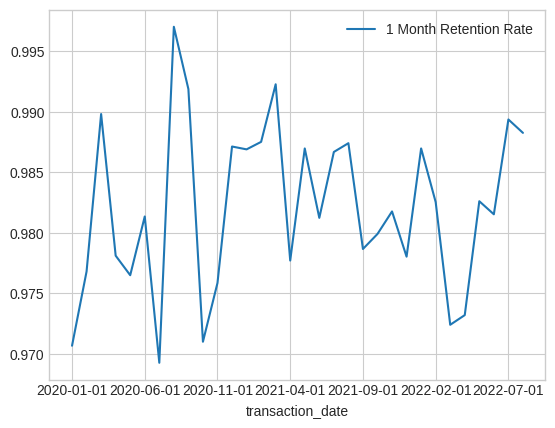

In [ ]:
pivot_2.plot(x='transaction_date', y='1 Month Retention Rate', kind='line')

<Axes: xlabel='transaction_date'>

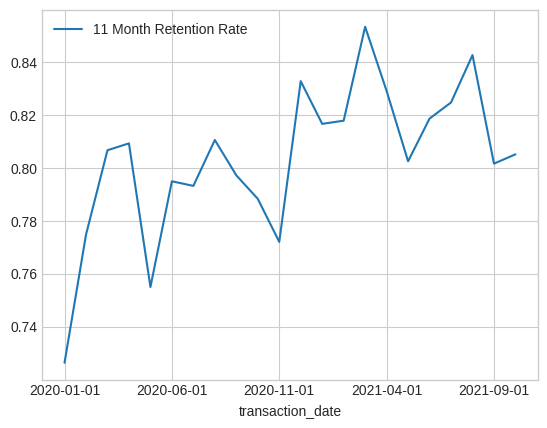

In [ ]:
pivot_2.plot(x='transaction_date', y='11 Month Retention Rate', kind='line')

<Axes: xlabel='transaction_date'>

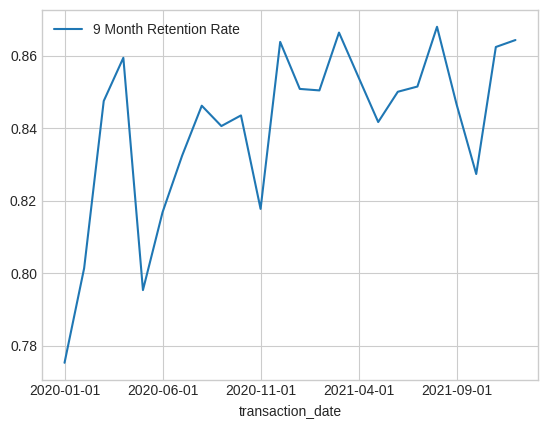

In [ ]:
pivot_2.plot(x='transaction_date', y='9 Month Retention Rate', kind='line')

In [ ]:
# Apply string formatting to the sorted retention columns
pivot_2[retention_columns] = pivot_2[retention_columns].applymap(lambda y: f"{y:.2f}" if pd.notna(y) else y)

<ipython-input-79-806f4b74120f>:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  pivot_2[retention_columns] = pivot_2[retention_columns].applymap(lambda y: f"{y:.2f}" if pd.notna(y) else y)


In [ ]:
pivot_2

transaction_date  2020-04-01  2020-05-01  2020-06-01  2020-07-01  \
0        2020-01-01           9          13          20          30   
1        2020-02-01         NaN           7           8          14   
2        2020-03-01         NaN         NaN           3           9   
3        2020-04-01         NaN         NaN         NaN           7   
4        2020-05-01         NaN         NaN         NaN         NaN   
5        2020-06-01         NaN         NaN         NaN         NaN   
6        2020-07-01         NaN         NaN         NaN         NaN   
7        2020-08-01         NaN         NaN         NaN         NaN   
8        2020-09-01         NaN         NaN         NaN         NaN   
9        2020-10-01         NaN         NaN         NaN         NaN   
10       2020-11-01         NaN         NaN         NaN         NaN   
11       2020-12-01         NaN         NaN         NaN         NaN   
12       2021-01-01         NaN         NaN         NaN         NaN   
13       2021-02-01         NaN         NaN         NaN         NaN   
14       2021-03-01         NaN         NaN         NaN         NaN   
15       2021-04-01         NaN         NaN         NaN         NaN   
16       2021-05-01         NaN         NaN         NaN         NaN   
17       2021-06-01         NaN         NaN         NaN         NaN   
18       2021-07-01         NaN         NaN         NaN         NaN   
19       2021-08-01         NaN         NaN         NaN         NaN   
20       2021-09-01         NaN         NaN         NaN         NaN   
21       2021-10-01         NaN         NaN         NaN         NaN   
22       2021-11-01         NaN         NaN         NaN         NaN   
23       2021-12-01         NaN         NaN         NaN         NaN   
24       2022-01-01         NaN         NaN         NaN         NaN   
25       2022-02-01         NaN         NaN         NaN         NaN   
26       2022-03-01         NaN         NaN         NaN         NaN   
27       2022-04-01         NaN         NaN         NaN         NaN   
28       2022-05-01         NaN         NaN         NaN         NaN   
29       2022-06-01         NaN         NaN         NaN         NaN   
30       2022-07-01         NaN         NaN         NaN         NaN   
31       2022-08-01         NaN         NaN         NaN         NaN   
32       2022-09-01         NaN         NaN         NaN         NaN   
33       2022-10-01         NaN         NaN         NaN         NaN   
34       2022-11-01         NaN         NaN         NaN         NaN   
35       2022-12-01         NaN         NaN         NaN         NaN   

    2020-08-01  2020-09-01  2020-10-01  2020-11-01  2020-12-01  2021-01-01  \
0           43          55          62          65          69          78   
1           19          28          34          43          52          60   
2           14          20          23          30          35          38   
3           13          19          22          24          32          36   
4            7          15          22          30          34          40   
5          NaN           6          11          19          26          33   
6          NaN         NaN          11          15          26          32   
7          NaN         NaN         NaN           1           6          10   
8          NaN         NaN         NaN         NaN           3          21   
9          NaN         NaN         NaN         NaN         NaN          10   
10         NaN         NaN         NaN         NaN         NaN         NaN   
11         NaN         NaN         NaN         NaN         NaN         NaN   
12         NaN         NaN         NaN         NaN         NaN         NaN   
13         NaN         NaN         NaN         NaN         NaN         NaN   
14         NaN         NaN         NaN         NaN         NaN         NaN   
15         NaN         NaN         NaN         NaN         NaN         NaN   
16         NaN         NaN         NaN         Na

TypeError: no numeric data to plot

In [ ]:
# Assuming the rightmost column contains the number of active instances
active_column = pivot_1.columns[-1]

# Calculate the cumulative sum across the row, excluding the rightmost column
pivot_1['Cumulative_Sum'] = pivot_1.iloc[:, :-1].sum(axis=1)

# Divide the cumulative sum by the number of active instances
pivot_1['Retention Rate'] = 1 - (pivot_1['Cumulative_Sum'] / pivot_1[active_column])

# Drop the temporary 'Cumulative_Sum' column if it's not needed
pivot_1 = pivot_1.drop(columns=['Cumulative_Sum'])



In [ ]:
pivot_1['Retention Rate'] = pivot_1['Retention Rate'].apply(lambda x: f"{x:.2f}")

In [ ]:
pivot_2 = pd.concat([pivot_1, df_cumsum2], axis=0)

NameError: name 'df_cumsum2' is not defined

In [ ]:
pivot_2

transaction_date  2020-04-01  2020-05-01  2020-06-01  2020-07-01  \
0        2020-01-01           9           4           7          10   
1        2020-02-01         NaN           7           1           6   
2        2020-03-01         NaN         NaN           3           6   
3        2020-04-01         NaN         NaN         NaN           7   
4        2020-05-01         NaN         NaN         NaN         NaN   
5        2020-06-01         NaN         NaN         NaN         NaN   
6        2020-07-01         NaN         NaN         NaN         NaN   
7        2020-08-01         NaN         NaN         NaN         NaN   
8        2020-09-01         NaN         NaN         NaN         NaN   
9        2020-10-01         NaN         NaN         NaN         NaN   
10       2020-11-01         NaN         NaN         NaN         NaN   
11       2020-12-01         NaN         NaN         NaN         NaN   
12       2021-01-01         NaN         NaN         NaN         NaN   
13       2021-02-01         NaN         NaN         NaN         NaN   
14       2021-03-01         NaN         NaN         NaN         NaN   
15       2021-04-01         NaN         NaN         NaN         NaN   
16       2021-05-01         NaN         NaN         NaN         NaN   
17       2021-06-01         NaN         NaN         NaN         NaN   
18       2021-07-01         NaN         NaN         NaN         NaN   
19       2021-08-01         NaN         NaN         NaN         NaN   
20       2021-09-01         NaN         NaN         NaN         NaN   
21       2021-10-01         NaN         NaN         NaN         NaN   
22       2021-11-01         NaN         NaN         NaN         NaN   
23       2021-12-01         NaN         NaN         NaN         NaN   
24       2022-01-01         NaN         NaN         NaN         NaN   
25       2022-02-01         NaN         NaN         NaN         NaN   
26       2022-03-01         NaN         NaN         NaN         NaN   
27       2022-04-01         NaN         NaN         NaN         NaN   
28       2022-05-01         NaN         NaN         NaN         NaN   
29       2022-06-01         NaN         NaN         NaN         NaN   
30       2022-07-01         NaN         NaN         NaN         NaN   
31       2022-08-01         NaN         NaN         NaN         NaN   
32       2022-09-01         NaN         NaN         NaN         NaN   
33       2022-10-01         NaN         NaN         NaN         NaN   
34       2022-11-01         NaN         NaN         NaN         NaN   
35       2022-12-01         NaN         NaN         NaN         NaN   

    2020-08-01  2020-09-01  2020-10-01  2020-11-01  2020-12-01  2021-01-01  \
0           13          12           7           3           4           9   
1            5           9           6           9           9           8   
2            5           6           3           7           5           3   
3            6           6           3           2           8           4   
4            7           8           7           8           4           6   
5          NaN           6           5           8           7           7   
6          NaN         NaN          11           4          11           6   
7          NaN         NaN         NaN           1           5           4   
8          NaN         NaN         NaN         NaN           3          18   
9          NaN         NaN         NaN         NaN         NaN          10   
10         NaN         NaN         NaN         NaN         NaN         NaN   
11         NaN         NaN         NaN         NaN         NaN         NaN   
12         NaN         NaN         NaN         NaN         NaN         NaN   
13         NaN         NaN         NaN         NaN         NaN         NaN   
14         NaN         NaN         NaN         NaN         NaN         NaN   
15         NaN         NaN         NaN         NaN         NaN         NaN   
16         NaN         NaN         NaN         Na

In [ ]:
pivot_1 = pivot_1.reset_index()

In [ ]:
pivot_2 = pivot_1.merge(df_cumsum, how='outer')

In [ ]:
# Automatically identify the rightmost column as the active instances column
active_column = pivot_1.columns[-2]  # assuming the last column is 'Result' and the second to last is the active instances

# Function to calculate retention rates
def calculate_retention_rates(row):
    rates = {}
    active_value = row[active_column]

    # Iterate over the columns except 'Initial Date', 'Result', and the active column
    retention_count = 1
    for col in row.index[1:-2]:  # Skip 'Initial Date', 'Result', and include up to the active column
        if pd.notna(row[col]):
            rate_column_name = f"{retention_count} Month Retention Rate"
            rates[rate_column_name] = 1 - (row[col] / active_value)
            retention_count += 1

    return pd.Series(rates)

# Apply the function to each row and create new columns with retention rates
retention_rates_df = pivot_1.apply(calculate_retention_rates, axis=1)

# Concatenate the retention rates DataFrame with the original DataFrame
pivot_2 = pd.concat([pivot_1, retention_rates_df], axis=1)

# Extract retention columns and sort them by the numeric part of the header
retention_columns = sorted(
    [col for col in pivot_2.columns if 'Month Retention Rate' in col],
    key=lambda x: int(x.split()[0])
)

# Reorder the DataFrame columns
pivot_2 = pivot_2[pivot_1.columns.tolist() + retention_columns]

#pivot_2.iloc[:, -11:] = pivot_2.iloc[:, -11:].apply(lambda x: x.apply(lambda y: f"{y:.2f}" if pd.notna(y) else y))

In [ ]:
# Automatically identify the rightmost column as the active instances column
active_column = df.columns[-2]  # assuming the last column is 'Result' and the second to last is the active instances

# Function to calculate retention rates
def calculate_retention_rates(row):
    rates = {}
    active_value = row[active_column]

    # Iterate over the columns except 'Initial Date', 'Result', and the active column
    retention_count = 1
    for col in row.index[1:-2]:  # Skip 'Initial Date', 'Result', and include up to the active column
        if pd.notna(row[col]):
            rate_column_name = f"{retention_count} Month Retention Rate"
            rates[rate_column_name] = (1-(row[col])) / active_value
            retention_count += 1

    return pd.Series(rates)

# Apply the function to each row and create new columns with retention rates
retention_rates_df = df.apply(calculate_retention_rates, axis=1)

# Concatenate the retention rates DataFrame with the original DataFrame
final_df = pd.concat([df, retention_rates_df], axis=1)

# Extract retention columns and sort them by the numeric part of the header
retention_columns = sorted(
    [col for col in final_df.columns if 'Month Retention Rate' in col],
    key=lambda x: int(x.split()[0])
)

# Reorder the DataFrame columns
final_df = final_df[df.columns.tolist() + retention_columns_sorted]

# Apply string formatting to the last 11 columns to ensure two decimal places
final_df[retention_columns_sorted] = final_df[retention_columns_sorted].apply(lambda x: x.apply(lambda y: f"{y:.2f}" if pd.notna(y) else y))

# Display the final DataFrame with retention rates in formatted decimal places
print(final_df)

In [ ]:
# Function to calculate retention rates
def calculate_retention_rates(row):
    rates = {}
    active_value = row[active_column]

    # Iterate over the columns except 'Initial Date', 'Result', and the active column
    retention_count = 1
    for col in row.index[1:-2]:  # Skip 'Initial Date', 'Result', and include up to the active column
        if pd.notna(row[col]):
            rate_column_name = f"{retention_count} Month Retention Rate"
            rates[rate_column_name] = row[col] / active_value
            retention_count += 1

    return pd.Series(rates)

# Apply the function to each row and create new columns with retention rates
retention_rates_df = df.apply(calculate_retention_rates, axis=1)

# Concatenate the retention rates DataFrame with the original DataFrame
final_df = pd.concat([df, retention_rates_df], axis=1)

# Extract retention columns and sort them by the numeric part of the header
retention_columns = sorted(
    [col for col in final_df.columns if 'Month Retention Rate' in col],
    key=lambda x: int(x.split()[0])
)

# Reorder the DataFrame columns
final_df = final_df[df.columns.tolist() + retention_columns]

# Apply string formatting to the sorted retention columns
final_df[retention_columns] = final_df[retention_columns].applymap(lambda y: f"{y:.2f}" if pd.notna(y) else y)

In [ ]:
# Function to calculate retention rates
def calculate_retention_rates(row):
    retention = {}
    active_value = row[active_column]

    # Iterate over the columns except 'Initial Date', 'Result', and the active column
    retention_count = 1
    for col in row.index[1:-2]:  # Skip 'Initial Date', 'Result', and include up to the active column
        if pd.notna(row[col]):
            ret_column_name = f"{retention_count} Month Retention Rate"
            retention[ret_column_name] = row[col] / active_value
            retention_count += 1

    return pd.Series(rates)

# Apply the function to each row and create new columns with retention rates
retention_rates_df = df.apply(calculate_retention_rates, axis=1)

# Concatenate the retention rates DataFrame with the original DataFrame
final_df = pd.concat([df, retention_rates_df], axis=1)

# Extract retention columns and sort them by the numeric part of the header
retention_columns = sorted(
    [col for col in final_df.columns if 'Month Retention Rate' in col],
    key=lambda x: int(x.split()[0])
)

# Reorder the DataFrame columns
final_df = final_df[df.columns.tolist() + retention_columns]

# Apply string formatting to the sorted retention columns
final_df[retention_columns] = final_df[retention_columns].applymap(lambda y: f"{y:.2f}" if pd.notna(y) else y)

In [ ]:
pivot_2

Primary_Key Retention Rate
0                0            nan
1                1           1.00
2                2           1.00
3                3           1.00
4                4           1.00
5                5           1.00
6                6           1.00
7               10           1.00
8                8           1.00
9               10           1.00
10              12           1.00
11              13           1.00
12              14           1.00
13              15           1.00
14              28           1.00
15              23           1.00
16              18           1.00
17              19           1.00
18              43           1.00
19              21           1.00
20              22           1.00
21              23           1.00
22              25           1.00
23              54           1.00
24              27           1.00
25              50           1.00
26              29           1.00
27              57           1.00
28              31           1.00
29              54           1.00
30              34           1.00
31              35           1.00
32              36           1.00
33              91           1.00
34              43           1.00
35              39           1.00
36              40           1.00
37             133           1.00
38              43           1.00
39              44           1.00
40              88           1.00
41             134           1.00
42             104           1.00
43              82           1.00
44              99           1.00
45              86           1.00
46              51           1.00
47              63           1.00
48              58           1.00
49             159           1.00
50              56           1.00
51              57           1.00
52              59           1.00
53             194           1.00
54              61           1.00
55              62           1.00
56             197           1.00
57              65           1.00
58              67           1.00
59             227           1.00
60             128           1.00
61              70           1.00
62              71           1.00
63              97           1.00
64             116           1.00
65             137           1.00
66             174           1.00
67             147           1.00
68              78           1.00
69              80           1.00
70             207           1.00
71              93           1.00
72             120           1.00
73             136           1.00
74             126           1.00
75              84           1.00
76              86           1.00
77             213           1.00
78             132           1.00
79              89           1.00
80             284           1.00
81             105           1.00
82             185           1.00
83             179           1.00
84             172           1.00
85             200           1.00
86             296           1.00
87             271           1.00
88             108           1.00
89             313           1.00
90             136           1.00
91             102           1.00
92             165           1.00
93             162           1.00
94             106           1.00
95             177           1.00
96             108           1.00
97             272           1.00
98             290           1.00
99             339           1.00
100            128           1.00
101            404           1.00
102            252           1.00
103            387           1.00
104            401           1.00
105            238           1.00
106            119           1.00
107            249           1.00
108            374           1.00
109            181           1.00
110            240           1.00
111            125           1.00
112            439           1.00
113            514           1.00
114            128           1.00
115            226           1.00
116            148           

In [ ]:
pivot_2['Retention Rate'] = pivot_1['Retention Rate'].apply(lambda x: f"{x:.2f}")

In [ ]:
df_init = df5[df5['transaction_type']=='initial'].groupby('transaction_date')[['Primary_Key']].count().reset_index()
df_init['Primary_Key'].mean()

287.6388888888889

<Axes: xlabel='Churn_Date'>

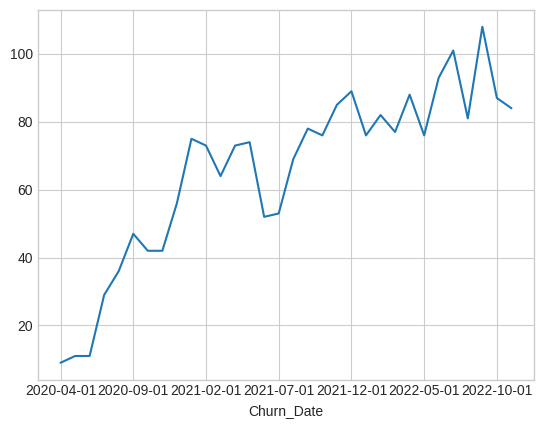

In [ ]:
df5[df5['Churn_Date']!='2050-01-01'].groupby('Churn_Date')['Primary_Key'].count().plot(kind='line')

In [ ]:
df5.groupby('Churn_Date')[['Primary_Key']].count().reset_index().sort_values(by='Churn_Date')

Churn_Date  Primary_Key
0   2020-04-01            9
1   2020-05-01           11
2   2020-06-01           11
3   2020-07-01           29
4   2020-08-01           36
5   2020-09-01           47
6   2020-10-01           42
7   2020-11-01           42
8   2020-12-01           56
9   2021-01-01           75
10  2021-02-01           73
11  2021-03-01           64
12  2021-04-01           73
13  2021-05-01           74
14  2021-06-01           52
15  2021-07-01           53
16  2021-08-01           69
17  2021-09-01           78
18  2021-10-01           76
19  2021-11-01           85
20  2021-12-01           89
21  2022-01-01           76
22  2022-02-01           82
23  2022-03-01           77
24  2022-04-01           88
25  2022-05-01           76
26  2022-06-01           93
27  2022-07-01          101
28  2022-08-01           81
29  2022-09-01          108
30  2022-10-01           87
31  2022-11-01           84
32  2050-01-01        13792

In [ ]:
df5.groupby('transaction_date')[['Primary_Key']].count().reset_index().sort_values(by='transaction_date')

transaction_date  Primary_Key
0        2020-01-01          307
1        2020-02-01          302
2        2020-03-01          295
3        2020-04-01          320
4        2020-05-01          298
5        2020-06-01          322
6        2020-07-01          358
7        2020-08-01          338
8        2020-09-01          370
9        2020-10-01          345
10       2020-11-01          373
11       2020-12-01          389
12       2021-01-01          382
13       2021-02-01          401
14       2021-03-01          389
15       2021-04-01          404
16       2021-05-01          461
17       2021-06-01          480
18       2021-07-01          451
19       2021-08-01          477
20       2021-09-01          469
21       2021-10-01          498
22       2021-11-01          494
23       2021-12-01          501
24       2022-01-01          538
25       2022-02-01          516
26       2022-03-01          580
27       2022-04-01          560
28       2022-05-01          518
29       2022-06-01          596
30       2022-07-01          565
31       2022-08-01          597
32       2022-09-01          525
33       2022-10-01          602
34       2022-11-01          593
35       2022-12-01          275

In [ ]:
df[df['cust_id'].duplicated(keep=False)==True][0:100]

Primary_Key  cust_id transaction_type transaction_date subscription_type  \
2              2        3          initial       2020-10-01               MAX   
3              3        3        REDUCTION       2022-02-01             BASIC   
8              8        8          initial       2021-01-01             BASIC   
9              9        8            CHURN       2021-04-01             BASIC   
10            10        9          initial       2020-08-01             BASIC   
11            11        9            CHURN       2021-03-01             BASIC   
13            13       11          initial       2020-05-01             BASIC   
14            14       11          UPGRADE       2022-01-01               MAX   
15            15       12          initial       2020-09-01             BASIC   
16            16       12          UPGRADE       2022-09-01               PRO   
18            18       14          initial       2020-03-01             BASIC   
19            19       14          UPGRADE       2020-07-01               PRO   
21            21       16          initial       2020-12-01               PRO   
22            22       16          UPGRADE       2022-11-01               MAX   
23            23       17          initial       2021-12-01             BASIC   
24            24       17            CHURN       2022-08-01             BASIC   
26            26       19          initial       2022-09-01               PRO   
27            27       19        REDUCTION       2022-10-01             BASIC   
29            29       21          initial       2021-09-01               PRO   
30            30       21          UPGRADE       2022-10-01               MAX   
31            31       22          initial       2022-06-01             BASIC   
32            32       22            CHURN       2022-11-01             BASIC   
33            33       23          initial       2020-12-01               MAX   
34            34       23        REDUCTION       2021-05-01               PRO   
35            35       24          initial       2021-03-01               MAX   
36            36       24        REDUCTION       2022-04-01               PRO   
37            37       25          initial       2020-12-01               MAX   
38            38       25        REDUCTION       2022-08-01             BASIC   
39            39       26          initial       2021-02-01             BASIC   
40            40       26          UPGRADE       2022-07-01               PRO   
41            41       26            CHURN       2022-10-01               PRO   
44            44       29          initial       2020-06-01               PRO   
45            45       29          UPGRADE       2022-07-01               MAX   
46            46       30          initial       2022-07-01               PRO   
47            47       30        REDUCTION       2022-10-01             BASIC   
48            48       31          initial       2021-05-01               PRO   
49            49       31          UPGRADE       2022-11-01               MAX   
51            51       33          initial       2021-09-01             BASIC   
52            52       33            CHURN       2022-09-01             BASIC   
56            56       37          initial       2020-02-01               PRO   
57            57       37          UPGRADE       2020-11-01               MAX   
58            58       37            CHURN       2020-11-01               PRO   
59            59       38          initial       2021-06-01               PRO   
60            60       38        REDUCTION       2022-07-01             BASIC   
61            61       39          initial       2020-08-01               PRO   
62            62       39          UPGRADE       2022-04-01               MAX   
63            63       39            CHURN       2022-07-01               MAX   
64            64       40          initial       2020-12-01               MAX   
65            65       40        RED

In [ ]:
df[(df['cust_id'] == 9765) | (df['cust_id'] == 4479) | (df['cust_id'] == 3)][['cust_id', 'transaction_type', 'transaction_date', 'subscription_type', 'Migration_Date']]

cust_id transaction_type transaction_date subscription_type  \
2            3          initial       2020-10-01               MAX   
3            3        REDUCTION       2022-02-01             BASIC   
7833      4479          initial       2021-02-01             BASIC   
7834      4479          UPGRADE       2021-06-01               PRO   
7835      4479            CHURN       2021-09-01               PRO   
7837      4479            CHURN       2022-03-01             BASIC   
17071     9765          initial       2020-08-01               PRO   
17072     9765            CHURN       2021-05-01               PRO   
17073     9765          UPGRADE       2022-04-01               MAX   
17075     9765            CHURN       2022-11-01               MAX   

      Migration_Date  
2                NaN  
3         2022-02-01  
7833             NaN  
7834      2021-06-01  
7835             NaN  
7837             NaN  
17071            NaN  
17072     2021-05-01  
17073     2022-04-01  
17075            NaN

In [ ]:
df[(df['cust_id'] == 9765) | (df['cust_id'] == 4479) | (df['cust_id'] == 3)][['cust_id', 'transaction_type', 'transaction_date', 'subscription_type', 'Migration_Date']]

cust_id transaction_type transaction_date subscription_type  \
2            3          initial       2020-10-01               MAX   
3            3        REDUCTION       2022-02-01             BASIC   
7833      4479          initial       2021-02-01             BASIC   
7834      4479          UPGRADE       2021-06-01               PRO   
7835      4479            CHURN       2021-09-01               PRO   
7837      4479            CHURN       2022-03-01             BASIC   
17071     9765          initial       2020-08-01               PRO   
17072     9765            CHURN       2021-05-01               PRO   
17073     9765          UPGRADE       2022-04-01               MAX   
17075     9765            CHURN       2022-11-01               MAX   

      Migration_Date  
2                NaN  
3         2022-02-01  
7833             NaN  
7834      2021-06-01  
7835      2021-09-01  
7837      2022-03-01  
17071            NaN  
17072     2021-05-01  
17073     2022-04-01  
17075     2022-11-01

In [ ]:
df[(df['cust_id'] == 9765) | (df['cust_id'] == 4479) | (df['cust_id'] == 3)][['cust_id', 'transaction_type', 'transaction_date', 'subscription_type', 'Migration_Date']]

cust_id transaction_type transaction_date subscription_type  \
2            3          initial       2020-10-01               MAX   
3            3        REDUCTION       2022-02-01             BASIC   
7833      4479          initial       2021-02-01             BASIC   
7834      4479          UPGRADE       2021-06-01               PRO   
7835      4479            CHURN       2021-09-01               PRO   
7837      4479            CHURN       2022-03-01             BASIC   
17071     9765          initial       2020-08-01               PRO   
17072     9765            CHURN       2021-05-01               PRO   
17073     9765          UPGRADE       2022-04-01               MAX   
17075     9765            CHURN       2022-11-01               MAX   

      Migration_Date  
2                NaN  
3         2022-02-01  
7833             NaN  
7834      2021-06-01  
7835      2021-09-01  
7837      2022-03-01  
17071            NaN  
17072     2021-05-01  
17073     2022-04-01  
17075     2022-11-01

In [ ]:
df[(df['cust_id'] == 9765) | (df['cust_id'] == 4479) | (df['cust_id'] == 3)][['cust_id', 'transaction_type', 'transaction_date', 'subscription_type', 'Migration_Date']]

cust_id transaction_type transaction_date subscription_type  \
2            3          initial       2020-10-01               MAX   
3            3        REDUCTION       2022-02-01             BASIC   
7833      4479          initial       2021-02-01             BASIC   
7834      4479          UPGRADE       2021-06-01               PRO   
7835      4479            CHURN       2021-09-01               PRO   
7837      4479            CHURN       2022-03-01             BASIC   
17071     9765          initial       2020-08-01               PRO   
17072     9765            CHURN       2021-05-01               PRO   
17073     9765          UPGRADE       2022-04-01               MAX   
17075     9765            CHURN       2022-11-01               MAX   

      Migration_Date  
2                NaN  
3         2022-02-01  
7833             NaN  
7834      2021-06-01  
7835      2021-09-01  
7837             NaN  
17071            NaN  
17072            NaN  
17073     2022-04-01  
17075     2022-11-01

In [ ]:
df[(df['cust_id'] == 9765) | (df['cust_id'] == 4479) | (df['cust_id'] == 3)][['cust_id', 'transaction_type', 'transaction_date', 'subscription_type', 'Migration_Date']]

cust_id transaction_type transaction_date subscription_type  \
2            3          initial       2020-10-01               MAX   
3            3        REDUCTION       2022-02-01             BASIC   
7833      4479          initial       2021-02-01             BASIC   
7834      4479          UPGRADE       2021-06-01               PRO   
7835      4479            CHURN       2021-09-01               PRO   
7837      4479            CHURN       2022-03-01             BASIC   
17071     9765          initial       2020-08-01               PRO   
17072     9765            CHURN       2021-05-01               PRO   
17073     9765          UPGRADE       2022-04-01               MAX   
17075     9765            CHURN       2022-11-01               MAX   

                                          Migration_Date  
2                                                    NaN  
3                                             2022-02-01  
7833                                                 NaN  
7834                                          2021-06-01  
7835   7834    2021-06-01
Name: transaction_date, dty...  
7837                                                 NaN  
17071                                                NaN  
17072                                                NaN  
17073                                         2022-04-01  
17075  17073    2022-04-01
Name: transaction_date, dt...

In [ ]:
df[(df['cust_id'] == 9765) | (df['cust_id'] == 4479) | (df['cust_id'] == 3)][['cust_id', 'transaction_type', 'transaction_date', 'subscription_type', 'Migration_Date']]

cust_id transaction_type transaction_date subscription_type  \
2            3          initial       2020-10-01               MAX   
3            3        REDUCTION       2022-02-01             BASIC   
7833      4479          initial       2021-02-01             BASIC   
7834      4479          UPGRADE       2021-06-01               PRO   
7835      4479            CHURN       2021-09-01               PRO   
7837      4479            CHURN       2022-03-01             BASIC   
17071     9765          initial       2020-08-01               PRO   
17072     9765            CHURN       2021-05-01               PRO   
17073     9765          UPGRADE       2022-04-01               MAX   
17075     9765            CHURN       2022-11-01               MAX   

      Migration_Date  
2                NaN  
3         2022-02-01  
7833             NaN  
7834      2021-06-01  
7835      2021-06-01  
7837             NaN  
17071            NaN  
17072            NaN  
17073     2022-04-01  
17075     2022-04-01

In [ ]:
df[(df['cust_id'] == 9765) | (df['cust_id'] == 4479) | (df['cust_id'] == 3)][['cust_id', 'transaction_type', 'transaction_date', 'subscription_type', 'Migration_Date']]

cust_id transaction_type transaction_date subscription_type  \
2            3          initial       2020-10-01               MAX   
3            3        REDUCTION       2022-02-01             BASIC   
7833      4479          initial       2021-02-01             BASIC   
7834      4479          UPGRADE       2021-06-01               PRO   
7835      4479            CHURN       2021-09-01               PRO   
7837      4479            CHURN       2022-03-01             BASIC   
17071     9765          initial       2020-08-01               PRO   
17072     9765            CHURN       2021-05-01               PRO   
17073     9765          UPGRADE       2022-04-01               MAX   
17075     9765            CHURN       2022-11-01               MAX   

      Migration_Date  
2                NaN  
3                NaN  
7833             NaN  
7834             NaN  
7835      2021-06-01  
7837             NaN  
17071            NaN  
17072            NaN  
17073            NaN  
17075     2022-04-01

In [ ]:
df[(df['cust_id'] == 9765) | (df['cust_id'] == 4479) | (df['cust_id'] == 3)][['cust_id', 'transaction_type', 'transaction_date', 'subscription_type', 'Migration_Date']]

cust_id transaction_type transaction_date subscription_type  \
2            3          initial       2020-10-01               MAX   
3            3        REDUCTION       2022-02-01             BASIC   
7833      4479          initial       2021-02-01             BASIC   
7834      4479          UPGRADE       2021-06-01               PRO   
7835      4479            CHURN       2021-09-01               PRO   
7837      4479            CHURN       2022-03-01             BASIC   
17071     9765          initial       2020-08-01               PRO   
17072     9765            CHURN       2021-05-01               PRO   
17073     9765          UPGRADE       2022-04-01               MAX   
17075     9765            CHURN       2022-11-01               MAX   

      Migration_Date  
2                NaN  
3                NaN  
7833             NaN  
7834             NaN  
7835      2021-06-01  
7837             NaN  
17071            NaN  
17072            NaN  
17073            NaN  
17075     2022-04-01

In [ ]:
df[(df['cust_id'] == 9765) | (df['cust_id'] == 4479) | (df['cust_id'] == 3)][['cust_id', 'transaction_type', 'transaction_date', 'subscription_type']]

cust_id transaction_type transaction_date subscription_type
2            3          initial       2020-10-01               MAX
3            3        REDUCTION       2022-02-01             BASIC
7833      4479          initial       2021-02-01             BASIC
7834      4479          UPGRADE       2021-06-01               PRO
7835      4479            CHURN       2021-09-01               PRO
7837      4479            CHURN       2022-03-01             BASIC
17071     9765          initial       2020-08-01               PRO
17072     9765            CHURN       2021-05-01               PRO
17073     9765          UPGRADE       2022-04-01               MAX
17075     9765            CHURN       2022-11-01               MAX

In [ ]:
df['Migration_Date'] = np.nan

# Iterate through each row to find the most recent UPGRADE or REDUCTION before each CHURN
for index, row in df.iterrows():
    if row['transaction_type'] == 'CHURN':
        cust_id = row['cust_id']
        subscription_type = row['subscription_type']
        churn_date = row['transaction_date']

        # Filter for UPGRADE/REDUCTION transactions before this CHURN
        prior_transactions = df[(df['cust_id'] == cust_id) &
                                (df['subscription_type'] == subscription_type) &
                                (df['transaction_date'] < churn_date) &
                                (df['transaction_type'].isin(['UPGRADE', 'REDUCTION']))]

        # If prior transactions exist, find the most recent one
        if not prior_transactions.empty:
            most_recent_transaction_date = prior_transactions['transaction_date'].max()
            df.at[index, 'Migration_Date'] = most_recent_transaction_date

<ipython-input-32-d6116a377b3b>:19: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2022-07-01' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.at[index, 'Migration_Date'] = most_recent_transaction_date


In [ ]:
df['transaction_type']=='REDUCTION'][0:10]

Primary_Key  cust_id transaction_type transaction_date subscription_type  \
3             3        3        REDUCTION       2022-02-01             BASIC   
27           27       19        REDUCTION       2022-10-01             BASIC   
34           34       23        REDUCTION       2021-05-01               PRO   
36           36       24        REDUCTION       2022-04-01               PRO   
38           38       25        REDUCTION       2022-08-01             BASIC   
47           47       30        REDUCTION       2022-10-01             BASIC   
60           60       38        REDUCTION       2022-07-01             BASIC   
65           65       40        REDUCTION       2021-10-01             BASIC   
68           68       41        REDUCTION       2022-10-01             BASIC   
71           71       43        REDUCTION       2021-10-01               PRO   

    subscription_price customer_gender age_group customer_country  \
3                   53          Female     25-34           Norway   
27                  53            Male     25-34           Norway   
34                  75          Female     35-44           Sweden   
36                  85          Female     18-24          Denmark   
38                  53          Female     35-44           Sweden   
47                  53            Male     45-54           Sweden   
60                  53            Male     25-34          Finland   
65                  43           Other     18-24          Denmark   
68                  53            Male     35-44           Sweden   
71                  75          Female     45-54           Sweden   

     referral_type  Deleted_Row  
3         facebook            0  
27  Organic Search            0  
34        facebook            0  
36        facebook            0  
38      Google Ads            0  
47            Bing            0  
60         Unknown            0  
65        facebook            0  
68      Google Ads            0  
71  Organic Search            0

In [ ]:
df[df['cust_id'] == 9765][['cust']]

In [ ]:
df.groupby(['transaction_type'])

In [ ]:
df_up = df[df['transaction_type']=='UPGRADE']
df_up = df_up.drop_duplicates()

In [ ]:
df2 = df.sort_values(by=['cust_id', 'subscription_type', 'transaction_date'])
df2 = df2.drop(columns='Deleted_Row')

In [ ]:
df2.groupby('cust_id')[['Primary_Key']].count().sort_values(by='Primary_Key', ascending=False)[0:10]

Primary_Key
cust_id             
8093               5
3946               5
1054               4
9956               4
1244               4
7652               4
7483               4
1615               4
6462               4
5922               4

In [ ]:
df2[df2['cust_id']==8093]

Primary_Key  cust_id transaction_type transaction_date  \
14138        14138     8093          UPGRADE       2021-04-01   
14140        14140     8093            CHURN       2021-08-01   
14137        14137     8093          initial       2020-12-01   
14139        14139     8093            CHURN       2021-07-01   
14141        14141     8093            CHURN       2021-11-01   

      subscription_type  subscription_price customer_gender age_group  \
14138               MAX                 109          Female     18-24   
14140               MAX                 109          Female     18-24   
14137               PRO                  65          Female     18-24   
14139               PRO                  75          Female     18-24   
14141               PRO                  75          Female     18-24   

      customer_country   referral_type  
14138          Finland  Organic Search  
14140          Finland  Organic Search  
14137          Finland  Organic Search  
14139          Finland  Organic Search  
14141          Finland  Organic Search

In [ ]:
df2 = df.groupby(['cust_id', 'subscription_type'])

In [ ]:
df2[0:100]

Primary_Key  cust_id transaction_type transaction_date subscription_type  \
0             0        1          initial       2020-09-01             BASIC   
1             1        2          initial       2022-03-01             BASIC   
3             3        3        REDUCTION       2022-02-01             BASIC   
2             2        3          initial       2020-10-01               MAX   
4             4        4          initial       2022-05-01               PRO   
5             5        5          initial       2022-08-01             BASIC   
6             6        6          initial       2022-06-01               MAX   
7             7        7          initial       2022-02-01               MAX   
8             8        8          initial       2021-01-01             BASIC   
9             9        8            CHURN       2021-04-01             BASIC   
10           10        9          initial       2020-08-01             BASIC   
11           11        9            CHURN       2021-03-01             BASIC   
12           12       10          initial       2022-09-01               MAX   
13           13       11          initial       2020-05-01             BASIC   
14           14       11          UPGRADE       2022-01-01               MAX   
15           15       12          initial       2020-09-01             BASIC   
16           16       12          UPGRADE       2022-09-01               PRO   
17           17       13          initial       2022-06-01             BASIC   
18           18       14          initial       2020-03-01             BASIC   
19           19       14          UPGRADE       2020-07-01               PRO   
20           20       15          initial       2022-06-01               PRO   
22           22       16          UPGRADE       2022-11-01               MAX   
21           21       16          initial       2020-12-01               PRO   
23           23       17          initial       2021-12-01             BASIC   
24           24       17            CHURN       2022-08-01             BASIC   
25           25       18          initial       2021-11-01             BASIC   
27           27       19        REDUCTION       2022-10-01             BASIC   
26           26       19          initial       2022-09-01               PRO   
28           28       20          initial       2022-11-01               PRO   
30           30       21          UPGRADE       2022-10-01               MAX   
29           29       21          initial       2021-09-01               PRO   
31           31       22          initial       2022-06-01             BASIC   
32           32       22            CHURN       2022-11-01             BASIC   
33           33       23          initial       2020-12-01               MAX   
34           34       23        REDUCTION       2021-05-01               PRO   
35           35       24          initial       2021-03-01               MAX   
36           36       24        REDUCTION       2022-04-01               PRO   
38           38       25        REDUCTION       2022-08-01             BASIC   
37           37       25          initial       2020-12-01               MAX   
39           39       26          initial       2021-02-01             BASIC   
40           40       26          UPGRADE       2022-07-01               PRO   
41           41       26            CHURN       2022-10-01               PRO   
42           42       27          initial       2020-12-01             BASIC   
43           43       28          initial       2022-07-01               PRO   
45           45       29          UPGRADE       2022-07-01               MAX   
44           44       29          initial       2020-06-01               PRO   
47           47       30        REDUCTION       2022-10-01             BASIC   
46           46       30          initial       2022-07-01               PRO   
49           49       31          UPGRADE       2022-11-01               MAX   
48  

In [ ]:
cond_cid = df['cust_id'] == df['cust_id'].shift(-1)
cond_up = df['transaction_type'].shift(-1) == 'UPGRADE'
cond_red = df['transaction_type'].shift(-1) == 'REDUCTION'
df['Churn_by_Upgrade'] = np.where((cond_cid) & (cond_up), 1, 0)
df['Churn_by_Downgrade'] = np.where((cond_cid) & (cond_red), 1, 0)

In [ ]:
#no_cid = df['cust_id'] != df['cust_id'].shift(1)
shift_churn = df['transaction_type'].shift(-1) == 'CHURN'
df['Churn_or_Migration_Date'] = np.where((shift_churn) & (c_id)), df['transaction_date'], np.NaN

In [ ]:
#no_cid = df['cust_id'] != df['cust_id'].shift(1)
cond_churn = df['transaction_type'] == 'CHURN'
df['Churn_or_Migration_Date'] = np.where(((cond_churn) | (cond_up)) | ((cond_churn) & (cond_red)), df['transaction_date'], '01-01-2080')

In [ ]:
df.columns

Index(['Primary_Key', 'cust_id', 'transaction_type', 'transaction_date',
       'subscription_type', 'subscription_price', 'customer_gender',
       'age_group', 'customer_country', 'referral_type', 'Churn_by_Upgrade',
       'Churn_by_Downgrade', 'Churn_or_Migration_Date'],
      dtype='object')

In [ ]:
df[['Primary_Key', 'cust_id', 'transaction_type', 'transaction_date',
       'subscription_type', 'Churn_by_Upgrade',
       'Churn_by_Downgrade', 'Churn_or_Migration_Date']][0:100]

Primary_Key  cust_id transaction_type transaction_date subscription_type  \
0             0        1          initial       2020-09-01             BASIC   
1             1        2          initial       2022-03-01             BASIC   
2             2        3          initial       2020-10-01               MAX   
3             3        3        REDUCTION       2022-02-01             BASIC   
4             4        4          initial       2022-05-01               PRO   
5             5        5          initial       2022-08-01             BASIC   
6             6        6          initial       2022-06-01               MAX   
7             7        7          initial       2022-02-01               MAX   
8             8        8          initial       2021-01-01             BASIC   
9             9        8            CHURN       2021-04-01             BASIC   
10           10        9          initial       2020-08-01             BASIC   
11           11        9            CHURN       2021-03-01             BASIC   
12           12       10          initial       2022-09-01               MAX   
13           13       11          initial       2020-05-01             BASIC   
14           14       11          UPGRADE       2022-01-01               MAX   
15           15       12          initial       2020-09-01             BASIC   
16           16       12          UPGRADE       2022-09-01               PRO   
17           17       13          initial       2022-06-01             BASIC   
18           18       14          initial       2020-03-01             BASIC   
19           19       14          UPGRADE       2020-07-01               PRO   
20           20       15          initial       2022-06-01               PRO   
21           21       16          initial       2020-12-01               PRO   
22           22       16          UPGRADE       2022-11-01               MAX   
23           23       17          initial       2021-12-01             BASIC   
24           24       17            CHURN       2022-08-01             BASIC   
25           25       18          initial       2021-11-01             BASIC   
26           26       19          initial       2022-09-01               PRO   
27           27       19        REDUCTION       2022-10-01             BASIC   
28           28       20          initial       2022-11-01               PRO   
29           29       21          initial       2021-09-01               PRO   
30           30       21          UPGRADE       2022-10-01               MAX   
31           31       22          initial       2022-06-01             BASIC   
32           32       22            CHURN       2022-11-01             BASIC   
33           33       23          initial       2020-12-01               MAX   
34           34       23        REDUCTION       2021-05-01               PRO   
35           35       24          initial       2021-03-01               MAX   
36           36       24        REDUCTION       2022-04-01               PRO   
37           37       25          initial       2020-12-01               MAX   
38           38       25        REDUCTION       2022-08-01             BASIC   
39           39       26          initial       2021-02-01             BASIC   
40           40       26          UPGRADE       2022-07-01               PRO   
41           41       26            CHURN       2022-10-01               PRO   
42           42       27          initial       2020-12-01             BASIC   
43           43       28          initial       2022-07-01               PRO   
44           44       29          initial       2020-06-01               PRO   
45           45       29          UPGRADE       2022-07-01               MAX   
46           46       30          initial       2022-07-01               PRO   
47           47       30        REDUCTION       2022-10-01             BASIC   
48           48       31          initial       2021-05-01               PRO   
49  

In [ ]:
cond_ch =
df['Churn_or_Migration_Date']

In [ ]:
df = pd.read_csv('Netflix Userbase.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'Netflix Userbase.csv'

In [ ]:
!ls /content/drive/My\ Drive/

'Application worksheet.gsheet'			       'Pressure Washing Proposal.gdoc'
'Approximate IER Tiering.gsheet'		       'PubMatic Cover Letter.gdoc'
'Automated and Manual Flows.gsheet'		       'PubMatic Notes.gdoc'
 Azuga.gdoc					       'Python code screenshots.gdoc'
'Becoming an AI Product Manager.gdoc'		       'sara,tom,melissa, andy'
'Brainstorming for Next47 dataset.gdoc'		       'Snowflake notes (1).gdoc'
'Calm Cover Letter.gdoc'			       'Snowflake notes.gdoc'
 Childhood					       'Solar Shiners Service Request.gform'
'Colab Notebooks'				       'Splice Case Prep.gdoc'
'College years'					       'Splice Cover Letter.gdoc'
'Cover letter for Futuri.gdoc'			       'Splice prep.gdoc'
'Cover Letter for Speak.gdoc'			        Spotify_data.xlsx
'Cover Letter - Next47.gdoc'			        Telestream.gdoc
 current_prospect_list_0724.xlsx		        top_3_list.gsheet
'David Marquardt Resume Feb_27_24.gdoc'		       'Transition Solutions.gdoc'
'David Marquardt Resume Mar_11_24.gdoc'		       'Uber Cover 

In [ ]:
from google.colab import drive
drive.flush_and_unmount()

!cp -r /content/drive/ForeView /content/ForeView

!ls /content/ForeView


Drive not mounted, so nothing to flush and unmount.
cp: cannot stat '/content/drive/ForeView': No such file or directory
ls: cannot access '/content/ForeView': No such file or directory


In [ ]:
from google.colab import drive
drive._mount('/content/drive')

ValueError: mount failed

In [ ]:
from google.colab import drive
drive.flush_and_unmount()

!cp -r /content/drive/My\ Drive/ForeView /content/ForeView

!ls /content/ForeView


Drive not mounted, so nothing to flush and unmount.
cp: cannot stat '/content/drive/My Drive/ForeView': No such file or directory
ls: cannot access '/content/ForeView': No such file or directory


In [ ]:

f/rom google.colab import drive
drive.mount('/content/MyDrive/ForeView', force_remount=True)

In [ ]:
df = pd.read_csv('Netflix Userbase.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'Netflix Userbase.csv'

In [ ]:
import os

# List all files and directories in the current directory
files = os.listdir('.')

# Print each file and directory
for file in files:
    print(file)

.config
drive_empty
sample_data


In [ ]:
drive.flush_and_unmount()

Drive not mounted, so nothing to flush and unmount.


In [ ]:
!mkdir -p /content/drive_empty

In [ ]:
from google.colab import drive
drive.mount('/content/drive_empty')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
!rm -rf /root/.config/gsutil
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

MessageError: Error: credential propagation was unsuccessful

In [ ]:
df = pd.read_csv('Netflix Userbase.csv')

FileNotFoundError: [Errno 2] No such file or directory: 'Netflix Userbase.csv'